<a href="https://colab.research.google.com/github/rgprado/SeriesTemporais/blob/main/Series_Temporais_aula1_202201_Rodrigo_Prado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Análise de Séries Temporais
 
 **Professor**: Domingos Santos

 **Aluno**: Rodrigo Prado

**Atividade 1**:

 - selecionar 2 séries: uma financeira e uma adicional (sugestão, uma disponível no pydataset)
 - plot da média movél 
 - análise de quais componentes foram observados nas séries (Tendência, Sazonalidade e ciclos)
 - Calcularem o ACF e PACF das séries
 - analisar a série "sem_nome", identificar os componentes e defina essa série 

**Atividade 2**: para cada uma das séries:

- aplicar o KPSSTest;
- caso necessite aplique a diferenciação;
- avaliação se precisa aplicar mais diferenciações;
- aplicar o auto.arima nas duas séries selecionadas, testar a abordagem direta (sem reajustar o modelo), e one step (ajustando o arima em cada passo)



In [1]:
!pip install yfinance pydataset pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
example_ma = [1,2,3,4,5,6,7,8,9,10]
ma_size=2

for i in range(ma_size, len(example_ma)):
  consider_val = example_ma[i-ma_size:i]
  print(f'valores considerados: {consider_val}, MA {np.mean(consider_val)}, valor atual {i}')

valores considerados: [1, 2], MA 1.5, valor atual 2
valores considerados: [2, 3], MA 2.5, valor atual 3
valores considerados: [3, 4], MA 3.5, valor atual 4
valores considerados: [4, 5], MA 4.5, valor atual 5
valores considerados: [5, 6], MA 5.5, valor atual 6
valores considerados: [6, 7], MA 6.5, valor atual 7
valores considerados: [7, 8], MA 7.5, valor atual 8
valores considerados: [8, 9], MA 8.5, valor atual 9


**Definição da função para cálculo da média movel**

In [4]:
def show_trend(ts, ma_size):
  to_show = pd.DataFrame()

  to_show['serie'] = ts.values[ma_size:]
  to_show['MA']  = ts.rolling(ma_size).mean().values[ma_size:]
  to_show.plot()
  plt.show()

**Definição da Funçao DIFF**


In [5]:
def differ(ts, interval=1):
  diff = list()

  for t in range(interval, ts.shape[0]):
    value = ts[t] - ts[t - interval]
    diff.append(value)


  return pd.Series(diff)

**Definição da função para busca de ações**


In [6]:
def get_yfinance(id_name):
  df = yf.Ticker(id_name)
  return  df.history(period="max")

**Definição da função para predict do modelo ARIMA**




In [7]:
def arima_fit_predict(ts, m, test_size):
  ts_train = ts[0:-test_size]
  ts_test = ts[-test_size:]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')

  model = auto_arima(ts_train.values, # X=None,
                    start_p=2, d=None, start_q=2, 
                    max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                    start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)
 
  direct_prev = model.predict(test_size)

  prevs_1_step = []
  for i in tqdm(ts_test):
    prevs_1_step.append(model.predict(1)[0])
    model.update(i)

  df_result = pd.DataFrame({
                          'arima_direct': direct_prev ,
                          'arima_1step': prevs_1_step,
                          'real': ts_test.values
                          })
  return df_result

**Definição da função para predict com horizonte do modelo ARIMA**

In [8]:
def arima_horizon_fit_predict(ts, m, test_size, horizon):
  horizon = horizon

  ts_train = ts[0:-(test_size+(horizon-1))]
  ts_test = ts[-(test_size+(horizon-1)):]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')
  model = auto_arima(ts_train.values, # X=None,
                      start_p=2, d=None, start_q=2, 
                      max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                      start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)

  prevs_step = []
  count = 0
  for i in tqdm(ts_test):
    print(f'fim do treino {count+ts_train.shape[0]}')
    prevs_step.append(model.predict(horizon)[horizon-1])
    model.update(i)
    count= count  +1

  df_result = pd.DataFrame({
                          f'arima_{horizon}step': prevs_step[0:-(horizon-1)],
                          'real': ts[-test_size:].values
                          })
  return df_result

##Definição de função para plot da série e diferentes previsões

In [9]:
def plot_predict(ts, ts_predict, test_size):
  TEST_SIZE = test_size
  data = ts
  train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
  x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
  print(train.shape, x_train.shape, test.shape, x_test.shape)

  arima_direct = ts_predict['arima_direct']
  arima_1step = ts_predict['arima_1step']
  real = ts_predict['real']
  arima_10step = ts_predict['arima_10step']

  fig, ax = plt.subplots(1, 1, figsize=(25, 7))
  ax.plot(x_train, train)
  ax.plot(x_test, arima_direct)
  ax.plot(x_test, arima_1step)
  ax.plot(x_test, arima_10step)
  ax.plot(x_test, real)
  plt.show()

## Definição da funções para cálculo do erro##

In [10]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


##Funções para criação da windowing, Gridsearch e Predict dos modelos##

In [11]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff).values

def inverse_difference(last_ob, value):
    return value + last_ob

def get_inverse_difference(last_ob,value):
     return [inverse_difference(last_ob[i], value[i]) for i in range(len(value))]

def create_windowing(ts, lag_size):
    df_final = None

    for i in range(0, (lag_size+1)):
        serie = ts.shift(i)
        if i==0:
          serie.name = 'actual'
        else:
          serie.name = f'lag_{i}'

        df_final = pd.concat([serie , df_final], axis=1)

    return df_final.dropna()

def holdout(actual_model, x_insampe, y_insampe, val_size):
  x_train = x_insampe[0:-val_size]
  y_train = y_insampe[0:-val_size]

  x_val = x_insampe[-val_size:]
  y_val = y_insampe[-val_size:]

  actual_model.fit(x_train, y_train.flatten())

  y_pred = actual_model.predict(x_val)

  return mean_absolute_error(y_val, y_pred)

def grid_search(base_model, list_params, x_insampe, 
                y_insampe, val_size):
  
  list_result = []
  for params in list_params:
    actual_model = clone(base_model).set_params(**params)
    val_metric = holdout(actual_model, x_insampe, y_insampe, val_size)
    list_result.append(val_metric)

  return list_result


def fit_predict_sklearn(ts, test_size, horizon, lag_size, 
                        model_sklearn, use_diff, list_params):
  # criacao de diferenca
  if use_diff:
    print('Criando diff da série temporal')
    diff_ts = pd.Series(difference(ts.values, interval=horizon))
  else:
    diff_ts = ts

  # criacao da janela
  print('Criando windowing')
  df_lagged_air = create_windowing(diff_ts , (lag_size+(horizon-1)))
  horizon_col = [f'actual_{i}' for i in range(1, horizon)] 
  lags_cols = [f'lag_{i}' for i in reversed(range(1, lag_size+1))]

  df_lagged_air.columns = lags_cols + horizon_col + ['actual']
  df_lagged_air.drop(columns=horizon_col, inplace=True)

  # treino e teste
  x_train = df_lagged_air.iloc[0:-test_size].drop(columns='actual').values
  y_train = df_lagged_air.iloc[0:-test_size]['actual'].values.reshape(-1, 1)

  x_test= df_lagged_air.iloc[-test_size:].drop(columns='actual').values
  y_test = df_lagged_air.iloc[-test_size:]['actual'].values.reshape(-1, 1)

  scaler_x = MinMaxScaler()
  scaler_y = MinMaxScaler()

  scaler_x.fit(x_train)
  scaler_y.fit(y_train)

  x_train_norm = scaler_x.transform(x_train)
  y_train_norm = scaler_y.transform(y_train)

  x_test_norm = scaler_x.transform(x_test)

  print('Encontrado os melhores parâmetros')
  val_metrics = grid_search(model_sklearn, list_params, x_train_norm, 
                            y_train_norm, test_size)
  
  best_index = np.argmin(val_metrics)
  best_param = list_params[best_index]
  best_model = clone(model_sklearn).set_params(**best_param)
  print('Treinando o modelo')
  best_model.fit(x_train_norm, y_train_norm.flatten())
  print('Gerando as previsões')
  prevs = best_model.predict(x_test_norm)

  prevs = scaler_y.inverse_transform(prevs.reshape(-1, 1)).flatten()
  if use_diff:
    base_inverse_diff = ts.values[-(test_size+horizon):-horizon]

    prevs = get_inverse_difference(base_inverse_diff, prevs)

  return prevs

**Função para criação do modelo MPL Regressor**

In [12]:
def create_mlp_model(ts, test_size, use_diff):
  parameters = {'hidden_layer_sizes': [20, 50, 100], 
                  'max_iter': [1000],
                  'tol': [0.001, 0.0001, 0.00001],
              }

  list_params = list(ParameterGrid(parameters))

  lag_size = 12
  horizon = 1
  test_size = test_size
  ts = ts
  model_sklearn = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic'
                              , solver='adam', learning_rate_init=0.01, 
                              power_t=0.5, max_iter=100000, random_state=None,
                              tol=0.0001 )
  
  use_diff = use_diff
  print('-- MLPRegressor --\n')
  print('Análise 1step:')
  prevs_mlp_1step = fit_predict_sklearn(ts, test_size, horizon, lag_size,
                                        model_sklearn, use_diff, list_params)

  print('\nAnálise 10step:')  
  prevs_mlp_10step = fit_predict_sklearn(ts, test_size, 10, lag_size,
                                        model_sklearn, use_diff, list_params)
  
  print('\nPrevisões 1step e 10step criados')

  
  return prevs_mlp_1step, prevs_mlp_10step

**Função para criação do modelo SVR**

In [13]:
def create_svr_model(ts, test_size, use_diff):
  parameters = {'C':[1, 10, 100 ], 'gamma': [0.1, 0.01, 0.001],
                    'kernel':["rbf"],
                    'epsilon': [0.1, 0.01, 0.001]
              }
  list_params = list(ParameterGrid(parameters))


  lag_size = 12
  horizon = 1
  test_size = test_size
  ts = ts
  model_sklearn = SVR()
  use_diff = use_diff

  print('-- SVR --\n')
  print('Análise 1step:')
  prevs_svr_1step = fit_predict_sklearn(ts, test_size, horizon, lag_size,
                                        model_sklearn, use_diff, list_params)

  print('\nAnálise 10step:')
  prevs_svr_10step = fit_predict_sklearn(ts, test_size, 10, lag_size,
                                        model_sklearn, use_diff, list_params)
  
  print('\nPrevisões 1step e 10step criados')
  
  return prevs_svr_1step, prevs_svr_10step


## Análise Financeira - Fechamento das ações da Berkshire Hathaway##

In [14]:
df_berkshire = get_yfinance('BRK-A')

In [15]:
df_berkshire

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,290.0,310.0,290.0,290.0,10000,0.0,0.0
1980-03-18 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-19 00:00:00-05:00,290.0,310.0,290.0,290.0,20000,0.0,0.0
1980-03-20 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-21 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-30 00:00:00-05:00,466790.0,469540.0,464932.0,465040.0,5300,0.0,0.0
2023-01-31 00:00:00-05:00,467724.0,473000.0,463085.0,473000.0,3900,0.0,0.0
2023-02-01 00:00:00-05:00,469923.0,473690.0,464527.0,470606.0,4400,0.0,0.0


**Análise:**

No gráfico de fechamento das ações da Berkshire Hathaway podemos observar uma tendência positiva na valorização das ações.

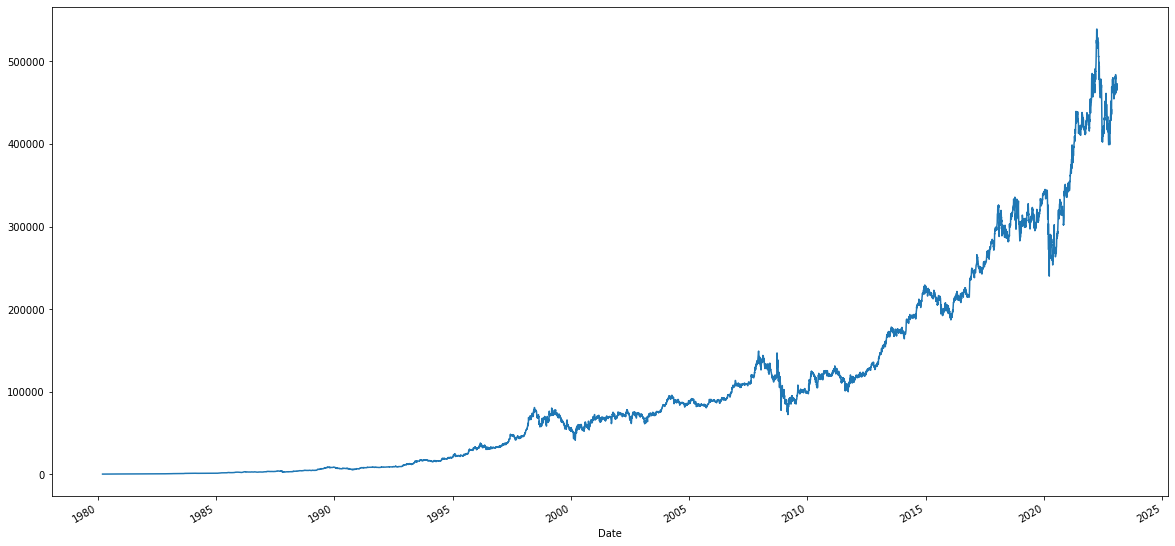

In [16]:
df_berkshire['Close'].plot()

**Dataset Berkshire Hathaway**

O dataset tem uma série histórica muito grande, o que deixou o processamento muito pesado/lento. Eu fiz um corte de 4 anos (2015 - 2019) para poder fazer as análises desse trabalho.

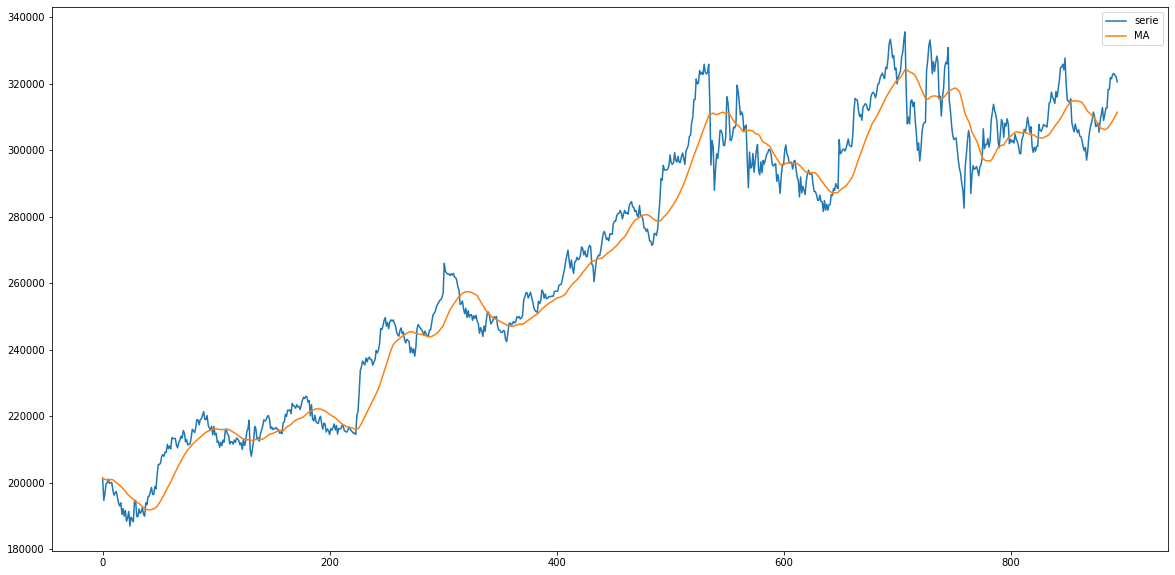

In [17]:
ts_berkshire = df_berkshire['Close'].iloc[-1825:-900]
ma_size=30
show_trend(ts_berkshire, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte entre os dias, analisado com um lag de 20.

Mas fazendo a análise parcial da correlação, podemos ver que o gráfico apresenta uma característica "Random Walk", correlação forte com t-1, porém o restante bastante variado e com média próxima de zero.

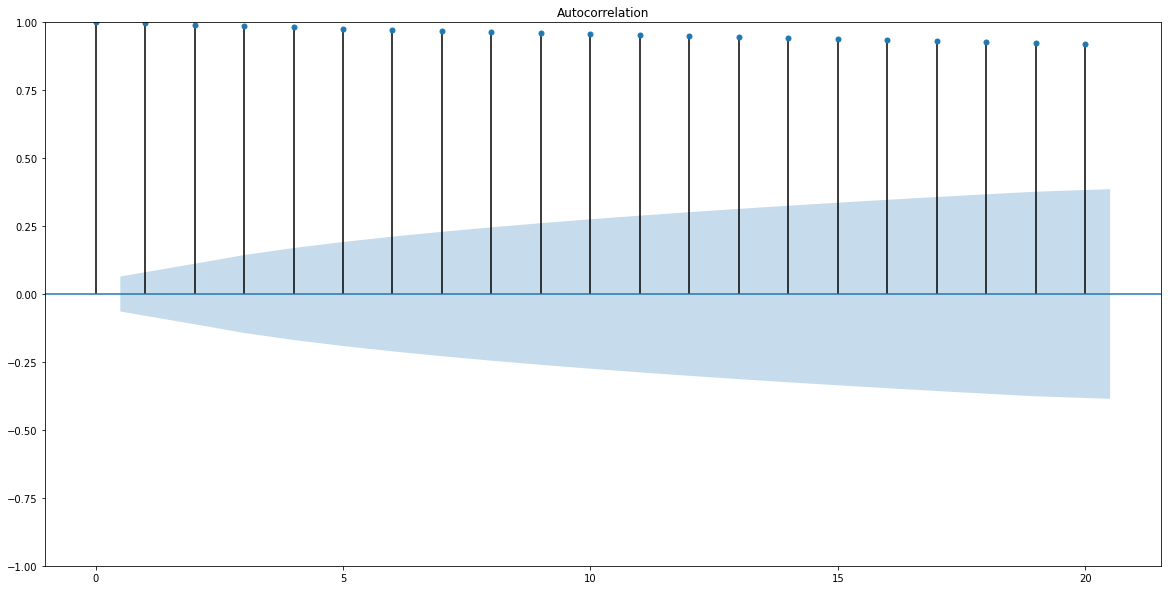

In [18]:
sm.graphics.tsa.plot_acf(ts_berkshire.values.squeeze(), lags=20)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


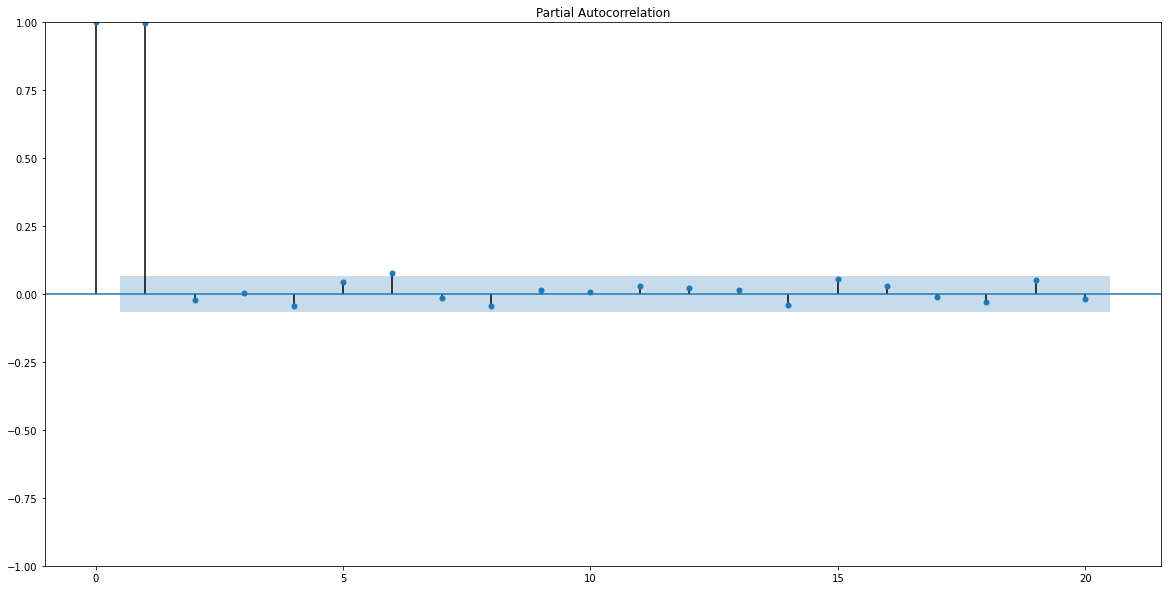

In [19]:
sm.graphics.tsa.plot_pacf(ts_berkshire.values.squeeze(), lags=20)

plt.show()

**Análise com função KPSSTest - Berkshire Hathaway**

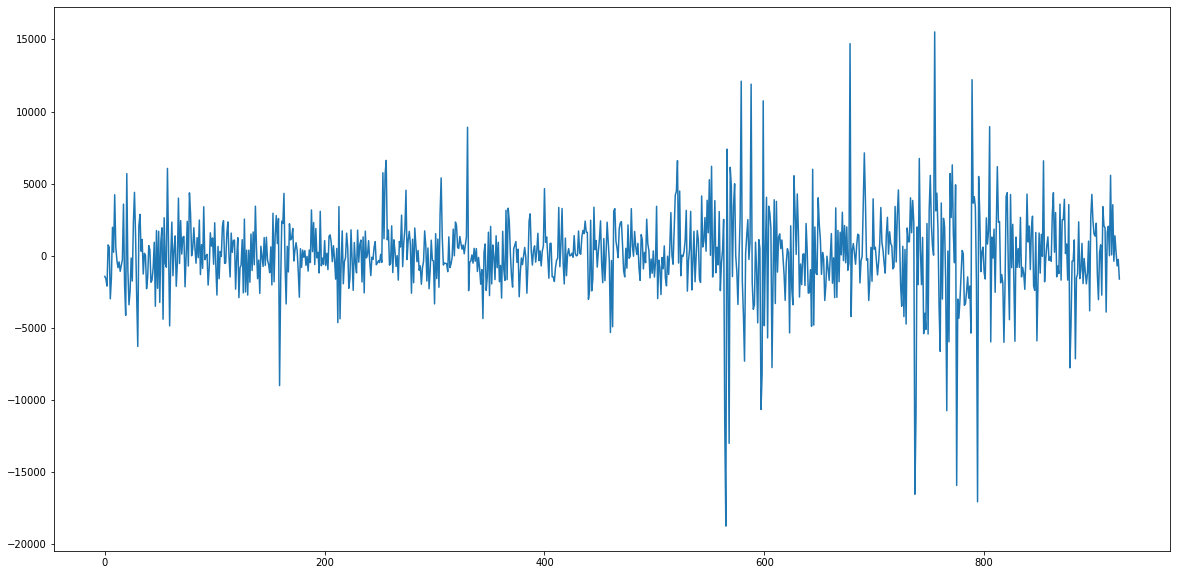

In [20]:
diff_finance = differ(ts_berkshire) # ou ts.diff()
diff_finance.plot()
plt.show()

In [21]:
kps = KPSSTest()
kps.should_diff(df_berkshire['Close'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série. 

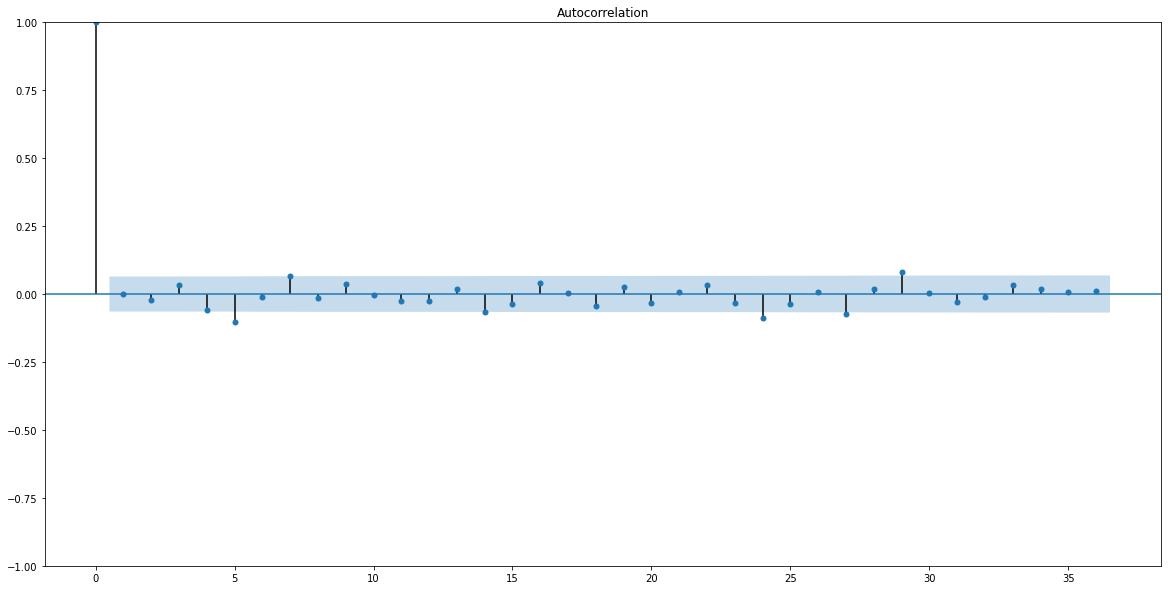

In [22]:
sm.graphics.tsa.plot_acf(diff_finance, lags=36)
plt.show()

**Análise**

Plot do PACF para o primeiro diff da série. 

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


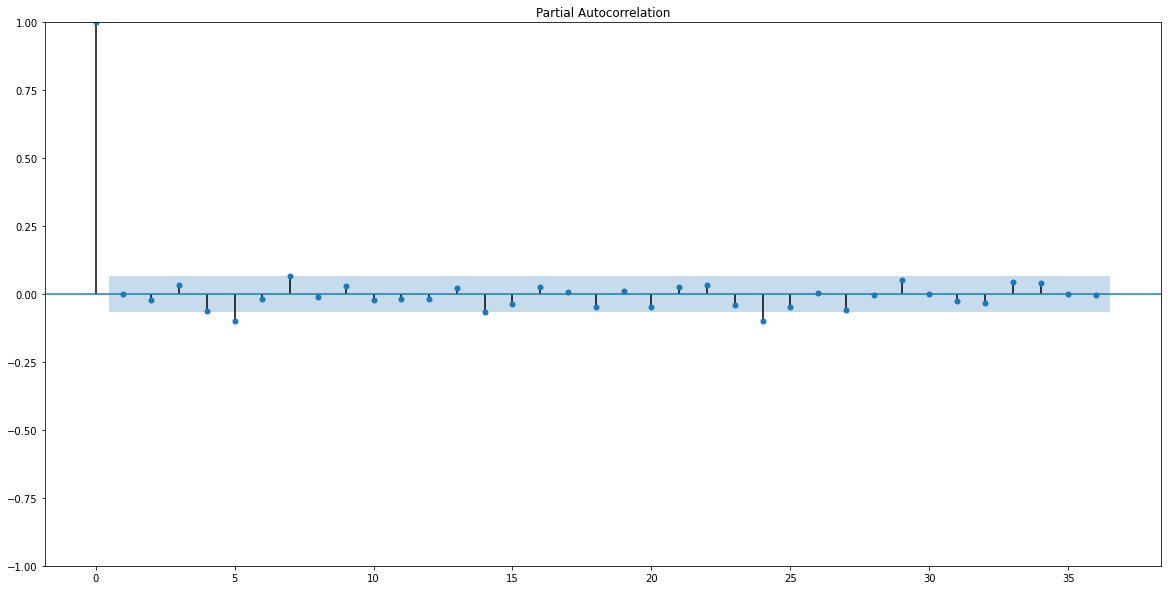

In [23]:
sm.graphics.tsa.plot_pacf(diff_finance, lags=36)
plt.show()

**Análise**

Verificando se é necessário fazer mais um diff na série. O retorno indica que não.

In [24]:
kps.should_diff(diff_finance)

(0.1, False)

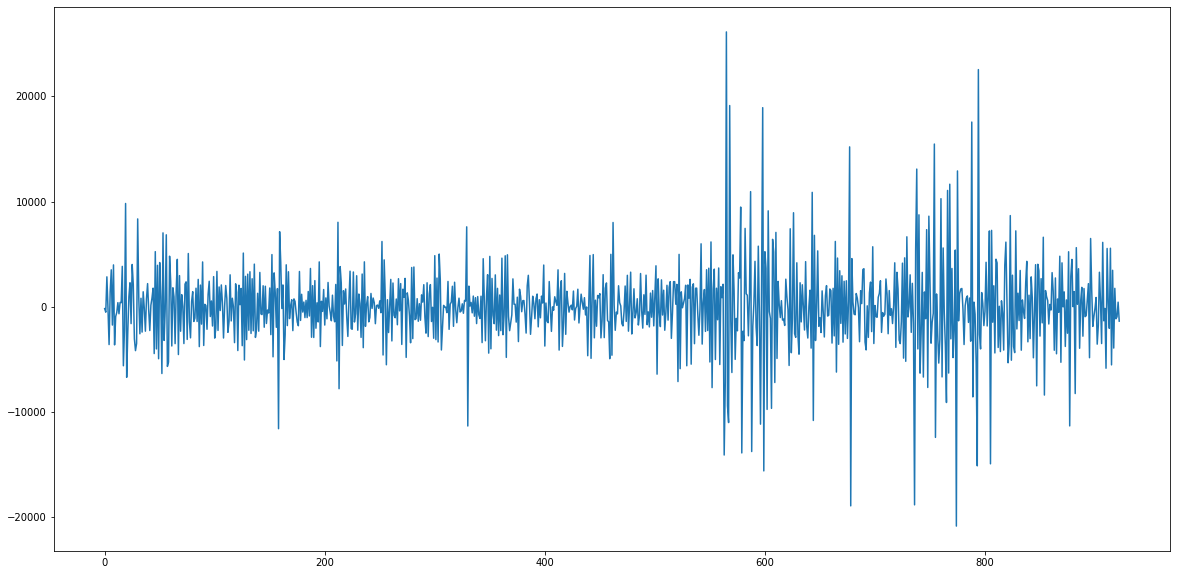

In [25]:
diff_finance2 = differ(diff_finance) # ou ts.diff()
diff_finance2.plot()
plt.show()

**Análise gráfica**

Plot do ACF e PACF da segunda diferença

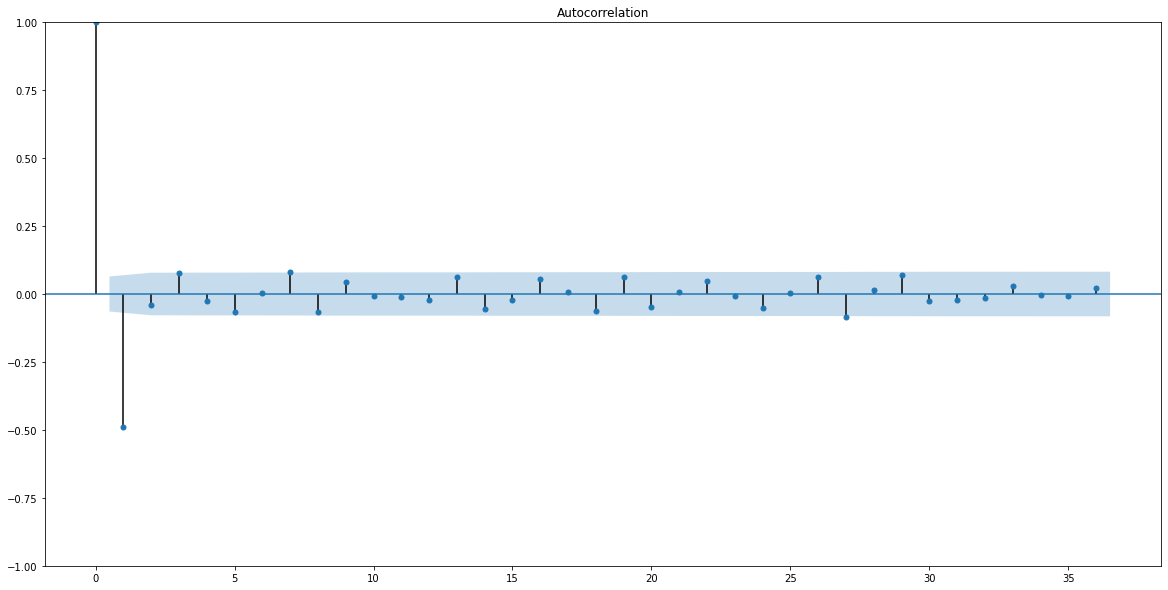

In [26]:
sm.graphics.tsa.plot_acf(diff_finance2, lags=36)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


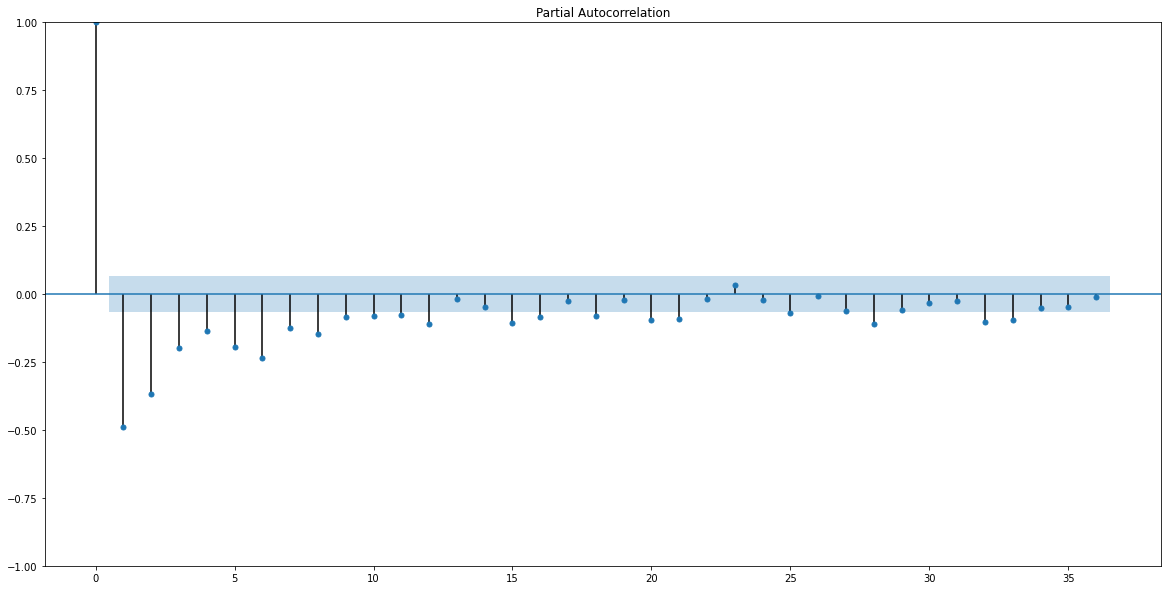

In [27]:
sm.graphics.tsa.plot_pacf(diff_finance2, lags=36)
plt.show()

**Análise**

Novo KPSSTest, agora retorno falso.

De acordo com a função de KPSSTest, o dados de fechamento da Berkshire precisariam da função diff e mesmo depois da primeira passagem, ainda seria necessário fazer mais uma differença.

In [28]:
kps.should_diff(diff_finance2)

(0.1, False)

##Criação do modelo com auto_arima##

Para criação do modelo não foram utilizados todos os dados da série temporal, somente os últimos 900.

In [29]:
auto_arima(ts_berkshire, # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17371.432, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17363.746, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17365.535, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17365.536, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17363.423, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17367.444, Time=0.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.540 seconds


ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##Fazendo predict de 1 step com auto_arima##

In [30]:
df_arima_berkshire = arima_fit_predict(ts_berkshire, 1, 90)

training shape (835,)
test shape (90,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15702.061, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15694.497, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15696.277, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15696.278, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15693.844, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15698.129, Time=2.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.925 seconds


100%|██████████| 90/90 [00:04<00:00, 20.23it/s]


##Fazendo predict de 10 steps (horizon) com auto_arima##

In [31]:
arima_hsteps = arima_horizon_fit_predict(ts_berkshire, 1, 90, 10)
df_arima_berkshire['arima_10step'] = arima_hsteps['arima_10step'].values

training shape (826,)
test shape (99,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15535.262, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15527.914, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15529.709, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15529.710, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15527.363, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15531.570, Time=1.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.034 seconds


  2%|▏         | 2/99 [00:00<00:05, 16.99it/s]

fim do treino 826
fim do treino 827
fim do treino 828
fim do treino 829


  8%|▊         | 8/99 [00:00<00:03, 23.33it/s]

fim do treino 830
fim do treino 831
fim do treino 832
fim do treino 833
fim do treino 834
fim do treino 835


 15%|█▌        | 15/99 [00:00<00:03, 27.93it/s]

fim do treino 836
fim do treino 837
fim do treino 838
fim do treino 839
fim do treino 840
fim do treino 841
fim do treino 842
fim do treino 843


 21%|██        | 21/99 [00:01<00:04, 17.40it/s]

fim do treino 844
fim do treino 845
fim do treino 846
fim do treino 847
fim do treino 848


 27%|██▋       | 27/99 [00:01<00:03, 20.69it/s]

fim do treino 849
fim do treino 850
fim do treino 851
fim do treino 852
fim do treino 853


 33%|███▎      | 33/99 [00:01<00:02, 22.83it/s]

fim do treino 854
fim do treino 855
fim do treino 856
fim do treino 857
fim do treino 858
fim do treino 859


 37%|███▋      | 37/99 [00:01<00:02, 24.54it/s]

fim do treino 860
fim do treino 861
fim do treino 862
fim do treino 863
fim do treino 864


 43%|████▎     | 43/99 [00:01<00:02, 23.42it/s]

fim do treino 865
fim do treino 866
fim do treino 867
fim do treino 868
fim do treino 869
fim do treino 870


 49%|████▉     | 49/99 [00:02<00:02, 24.74it/s]

fim do treino 871
fim do treino 872
fim do treino 873
fim do treino 874
fim do treino 875


 53%|█████▎    | 52/99 [00:02<00:02, 19.91it/s]

fim do treino 876
fim do treino 877


 56%|█████▌    | 55/99 [00:02<00:02, 19.53it/s]

fim do treino 878
fim do treino 879
fim do treino 880
fim do treino 881
fim do treino 882
fim do treino 883


 63%|██████▎   | 62/99 [00:02<00:01, 23.57it/s]

fim do treino 884
fim do treino 885
fim do treino 886
fim do treino 887
fim do treino 888
fim do treino 889


 69%|██████▊   | 68/99 [00:03<00:01, 24.98it/s]

fim do treino 890
fim do treino 891
fim do treino 892
fim do treino 893
fim do treino 894
fim do treino 895


 75%|███████▍  | 74/99 [00:03<00:01, 22.99it/s]

fim do treino 896
fim do treino 897
fim do treino 898
fim do treino 899
fim do treino 900


 81%|████████  | 80/99 [00:03<00:00, 23.99it/s]

fim do treino 901
fim do treino 902
fim do treino 903
fim do treino 904
fim do treino 905
fim do treino 906

 84%|████████▍ | 83/99 [00:03<00:00, 22.03it/s]


fim do treino 907
fim do treino 908
fim do treino 909


 90%|████████▉ | 89/99 [00:03<00:00, 24.37it/s]

fim do treino 910
fim do treino 911
fim do treino 912
fim do treino 913
fim do treino 914
fim do treino 915


 96%|█████████▌| 95/99 [00:04<00:00, 25.74it/s]

fim do treino 916
fim do treino 917
fim do treino 918
fim do treino 919
fim do treino 920
fim do treino 921


100%|██████████| 99/99 [00:04<00:00, 22.65it/s]


fim do treino 922
fim do treino 923
fim do treino 924


## Plot das previsões de 1 step, 10 steps, direct e real

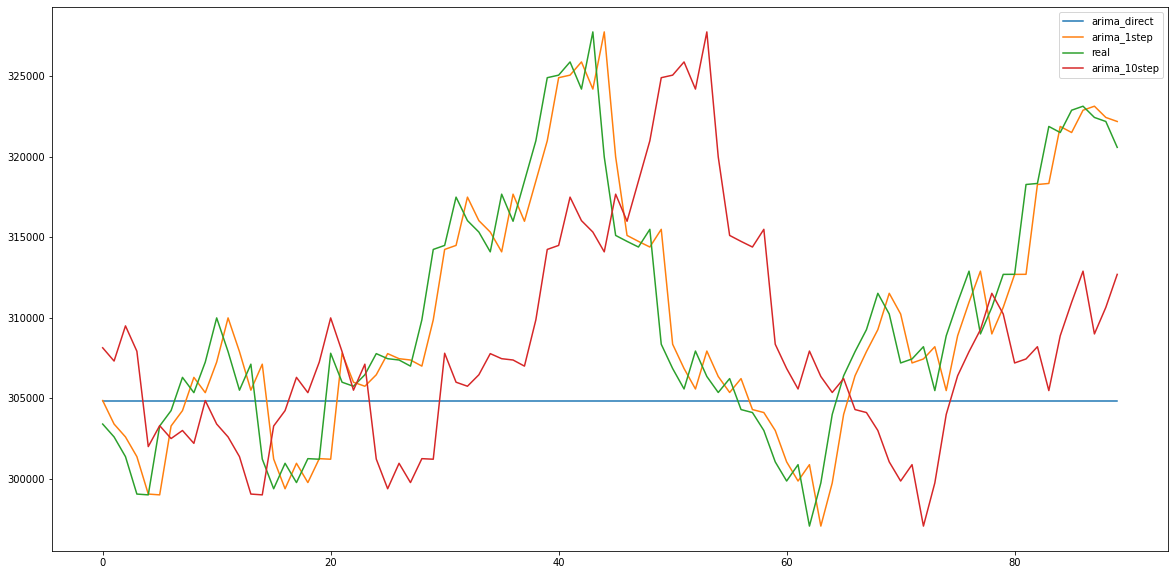

In [32]:
df_arima_berkshire.plot()

In [33]:
df_arima_berkshire.head()

,arima_direct,arima_1step,real,arima_10step
0,304860.0,304860.0,303400.0,308139.0
1,304860.0,303400.0,302600.0,307315.0
2,304860.0,302600.0,301375.0,309500.0
3,304860.0,301375.0,299050.0,307925.0
4,304860.0,299050.0,299000.0,302000.0


## Visão das previsões junto com os dados reais da Berkshire Hathaway

A visão tem relação somente com os anos entre 2015 e 2019

O tamanho utilizado para testes foi 90

(835,) (835,) (90,) (90,)


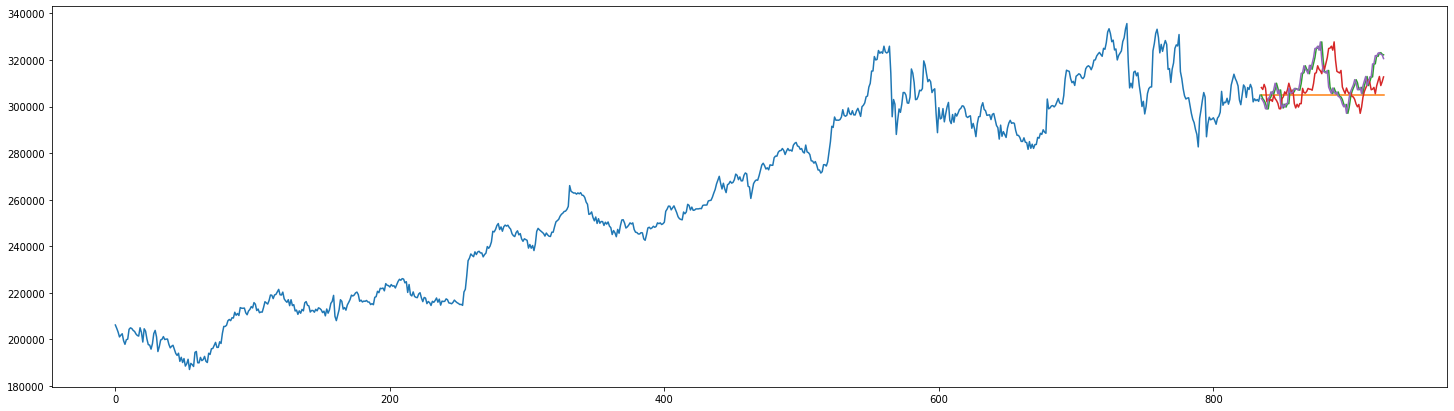

In [34]:
plot_predict(ts_berkshire, df_arima_berkshire, 90)

## Cálculo do Erro - Ações da Berkshire

In [35]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step']:

  dict_result = gerenerate_metric_results(df_arima_berkshire['real'], df_arima_berkshire[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

<ipython-input-10-978540aec463>:37: RuntimeWarning: divide by zero encountered in double_scalars
  return error_sup / error_inf


,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,8.384110e+07,9156.478642,2.191743,6918.233333,inf,3.070680,0.000000,arima_direct
1,6.420092e+06,2533.789987,0.627978,1948.100000,1.004501,0.115439,54.444444,arima_1step
2,7.705281e+07,8777.972772,2.403301,7482.177778,11.911222,1.629358,52.222222,arima_10step


##Definição da MLP - Berkshire##

**Criação do Modelo MLPRegressor e previsão dos dados**


In [36]:
ts_finance = ts_berkshire
test_size = 90
use_diff = True

prevs_mlp_1step, prevs_mlp_10step = create_mlp_model(ts_finance, test_size, use_diff)

-- MLPRegressor --
Análise 1step:
Criando diff da série temporal
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões

Análise 10step:
Criando diff da série temporal
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões
Previsões 1step e 10step criados


**Criação do Modelo SVR e previsão dos dados**


In [37]:
prevs_svr_1step, prevs_svr_10step = create_svr_model(ts_finance, test_size, use_diff)

-- SVR --
Análise 1step:
Criando diff da série temporal
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões

Análise 10step:
Criando diff da série temporal
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões
Previsões 1step e 10step criados


In [38]:
df_arima_berkshire['prevs_mlp_1step'] = prevs_mlp_1step
df_arima_berkshire['prevs_mlp_10step'] = prevs_mlp_10step
df_arima_berkshire['prevs_svr_1step'] = prevs_svr_1step
df_arima_berkshire['prevs_svr_10step'] = prevs_svr_10step

In [39]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'prevs_mlp_1step', 'prevs_svr_1step', 'arima_10step', 'prevs_mlp_10step', 'prevs_svr_10step']:

  dict_result = gerenerate_metric_results(df_arima_berkshire['real'], df_arima_berkshire[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

<ipython-input-10-978540aec463>:37: RuntimeWarning: divide by zero encountered in double_scalars
  return error_sup / error_inf


,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,8.384110e+07,9156.478642,2.191743,6918.233333,inf,3.070680,0.000000,arima_direct
1,6.420092e+06,2533.789987,0.627978,1948.100000,1.004501,0.115439,54.444444,arima_1step
2,6.614701e+06,2571.906035,0.644307,1997.446528,1.003586,0.114241,52.222222,prevs_mlp_1step
3,6.458332e+06,2541.324783,0.631775,1959.658333,1.096729,0.116687,52.222222,prevs_svr_1step
4,7.705281e+07,8777.972772,2.403301,7482.177778,11.911222,1.629358,52.222222,arima_10step
5,7.022180e+07,8379.845012,2.194021,6795.049551,11.159103,1.930105,53.333333,prevs_mlp_10step
6,7.128843e+07,8443.247341,2.261995,7025.117475,11.402213,1.946625,53.333333,prevs_svr_10step


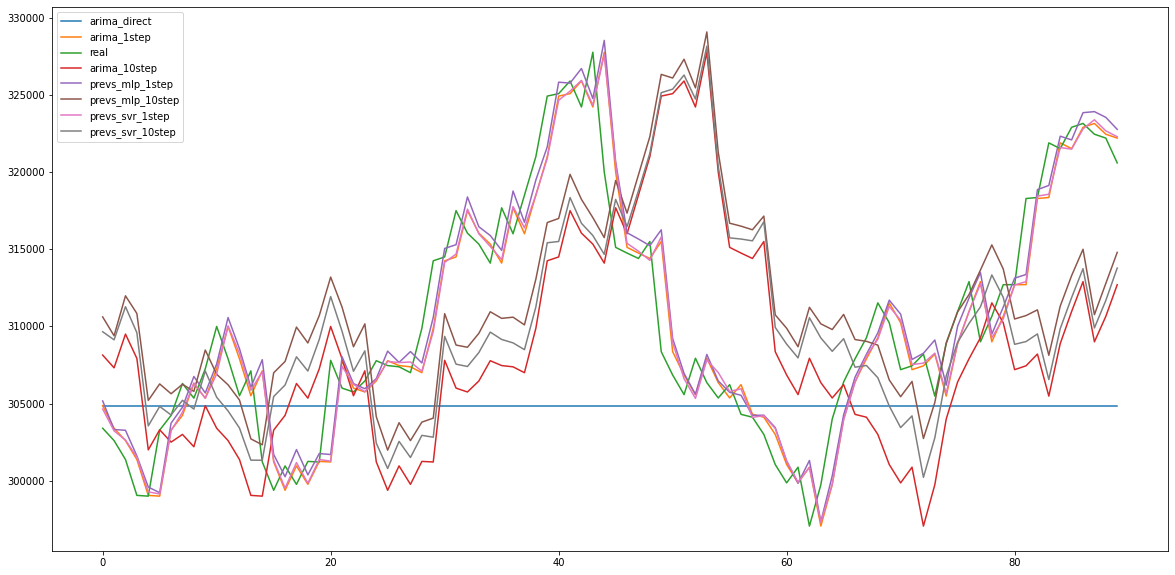

In [40]:
df_arima_berkshire.plot()

## Análise uma série temporal do pydataset - 'UKDriverDeaths'

In [41]:
timeseries_titles = ['AirPassengers', 'nottem', 'ambientNOxCH', 'acme', 'sunspot.year', 'UKDriverDeaths', 
                    'USAccDeaths', 'UKgas', 'JohnsonJohnson', 'Nile', 'LakeHuron', 'austres', 
                    'lynx', 'deaths', 'drivers']
                    
df_ukdrivers = data('UKDriverDeaths')

print(len(timeseries_titles))

15


In [42]:
data('UKDriverDeaths', show_doc=True )

UKDriverDeaths

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

##  Road Casualties in Great Britain 1969–84

### Description

`UKDriverDeaths` is a time series giving the monthly totals of car drivers in
Great Britain killed or seriously injured Jan 1969 to Dec 1984. Compulsory
wearing of seat belts was introduced on 31 Jan 1983.

`Seatbelts` is more information on the same problem.

### Usage

    UKDriverDeaths
    Seatbelts

### Format

`Seatbelts` is a multiple time series, with columns

`DriversKilled`

car drivers killed.

`drivers`

same as `UKDriverDeaths`.

`front`

front-seat passengers killed or seriously injured.

`rear`

rear-seat passengers killed or seriously injured.

`kms`

distance driven.

`PetrolPrice`

petrol price.

`VanKilled`

number of van (‘light goods vehicle’) drivers.

`law`

0/1: was the law in effect that month?

### Source

Harvey, A.C. (1989) _Forecasting, Structural Time Series Models and the Kalman
Filter._ Ca

In [43]:
df_ukdrivers['date'] = pd.date_range(start ='1969-01-01', end='1985-01-01', freq='M')

In [44]:
df_ukdrivers.set_index('date', inplace=True)

**Análise**:

No gráfico de mortes mensais no Reino Unido não há tendência, mas aparentemente existe uma sazonalidade e ciclo. Confirmado nos gráficos de média mensal.

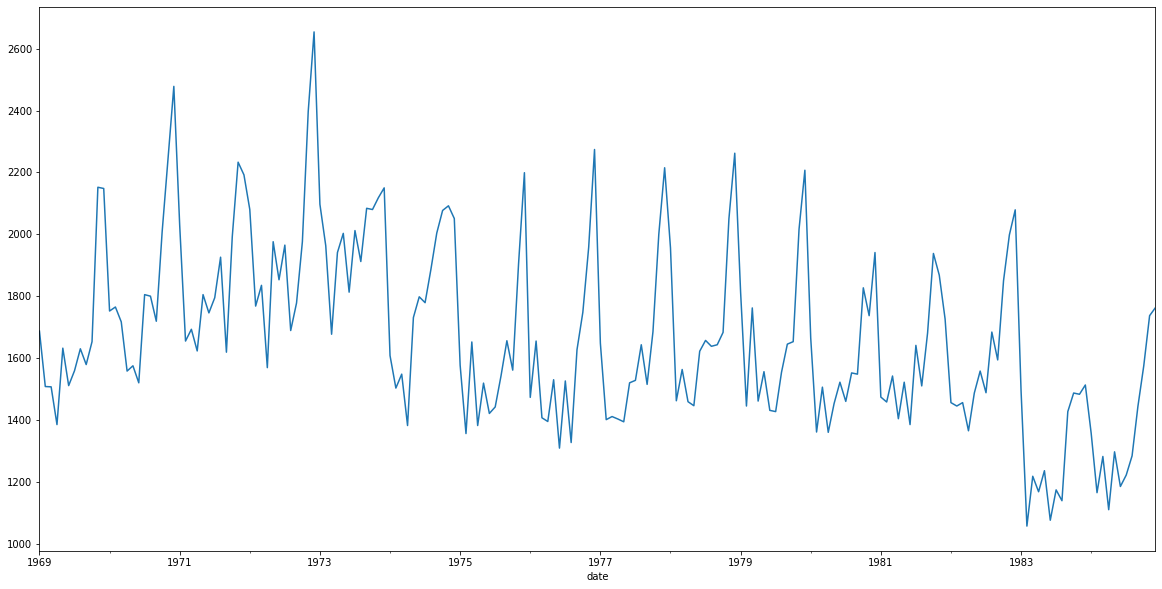

In [45]:
df_ukdrivers['UKDriverDeaths'].plot()

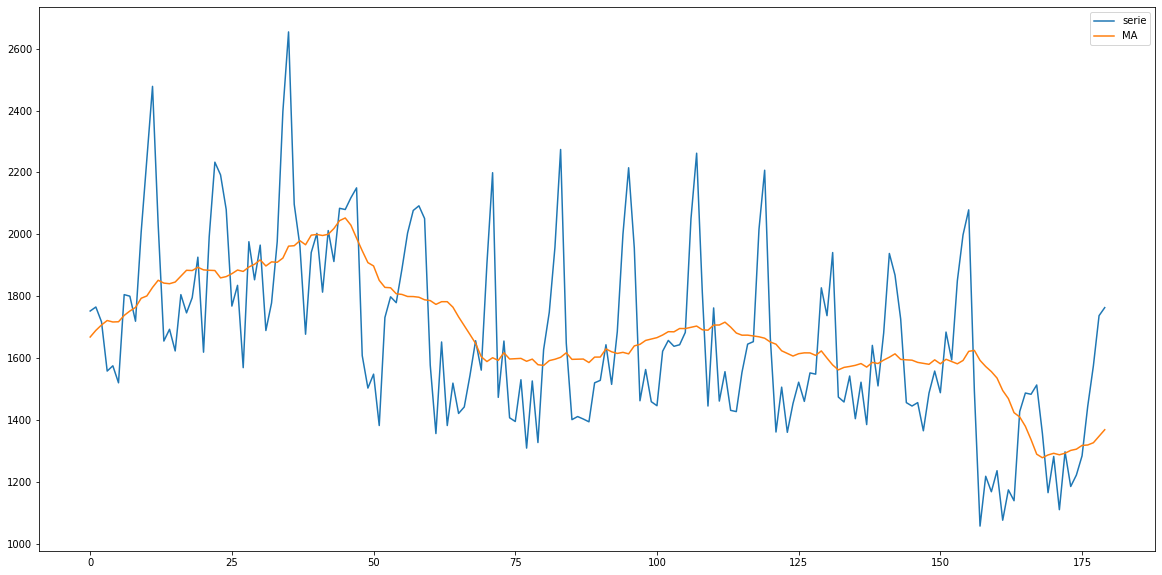

In [46]:
ts = df_ukdrivers['UKDriverDeaths']
ma_size=12
show_trend(ts, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte a cada 12 meses, indicando uma sazonalidade.

Na análise parcial da correlação, podemos ver que o gráfico apresenta uma característica de sazonalidade também, mas com correlação mais fraca nos depois de 12 e 24 meses.

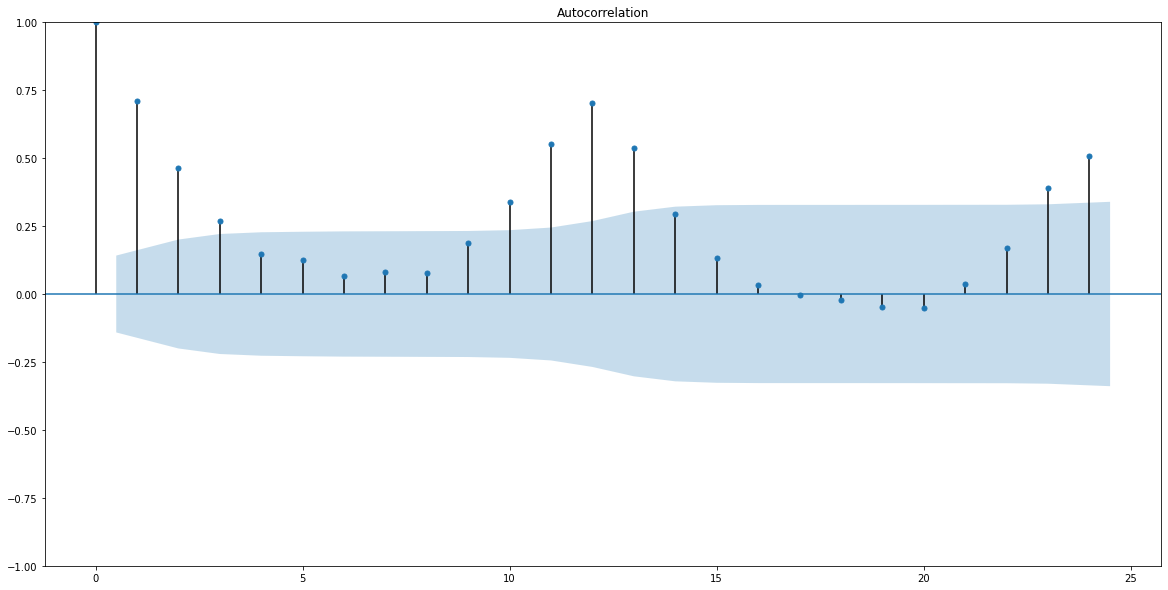

In [47]:
sm.graphics.tsa.plot_acf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


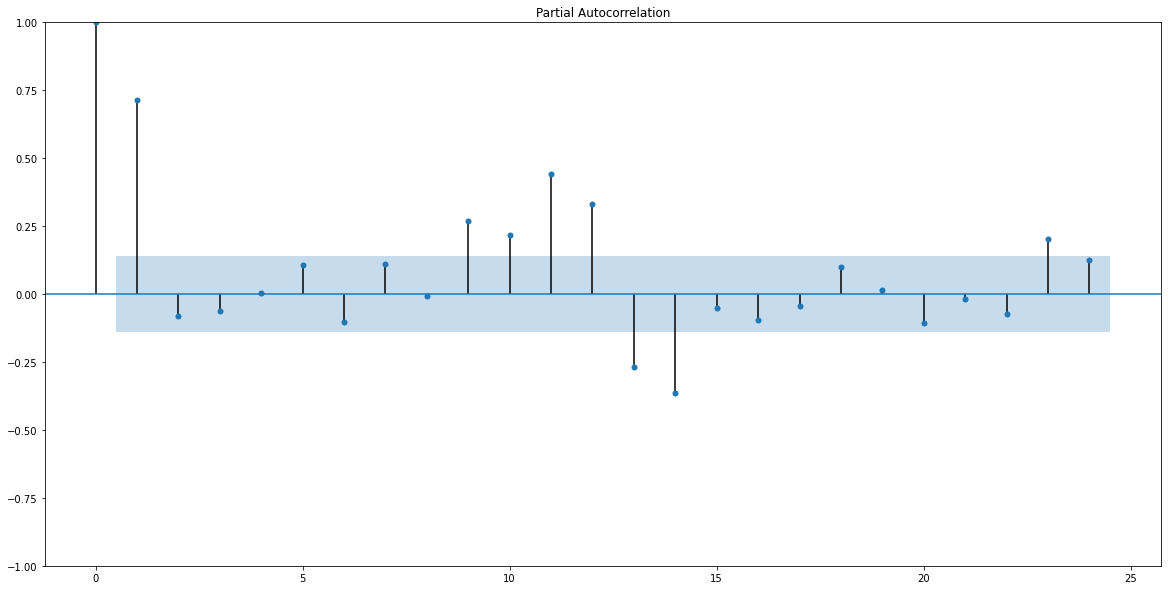

In [48]:
sm.graphics.tsa.plot_pacf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

**Análise com função KPSSTest - UKDriverDeaths**

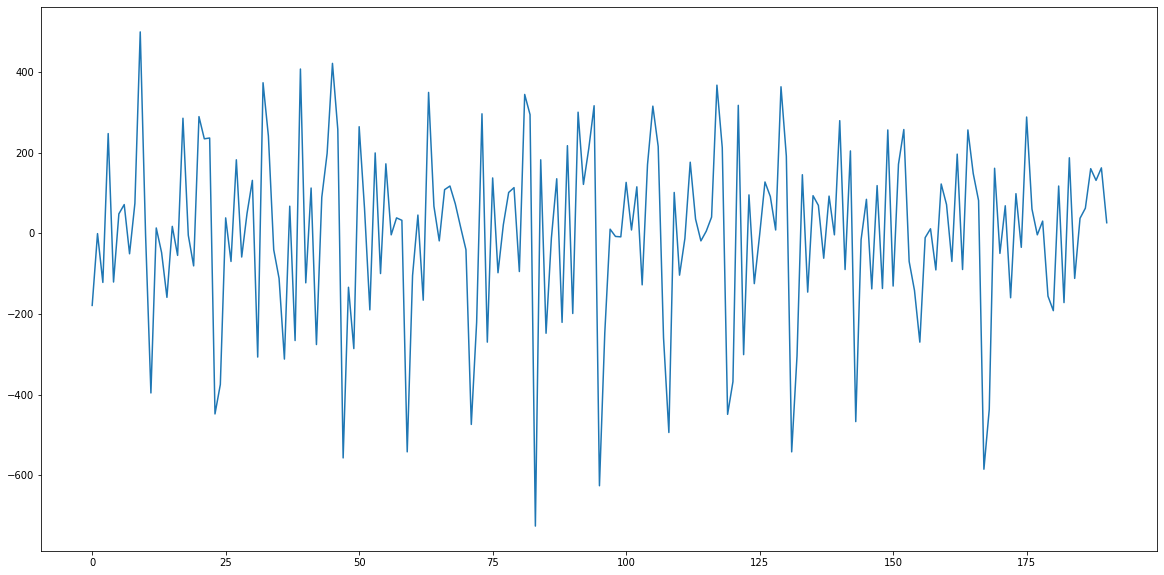

In [49]:
diff_ukdrivers = differ(df_ukdrivers['UKDriverDeaths']) # ou ts.diff()
diff_ukdrivers.plot()
plt.show()

In [50]:
kps.should_diff(df_ukdrivers['UKDriverDeaths'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série UKDriverDeaths. 

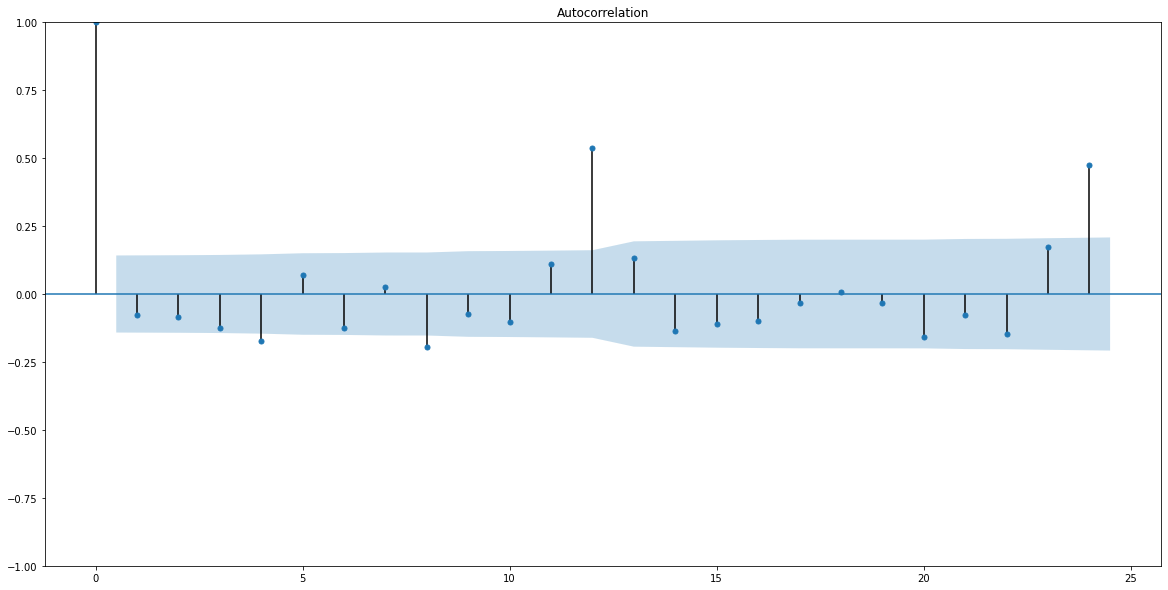

In [51]:
sm.graphics.tsa.plot_acf(diff_ukdrivers, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


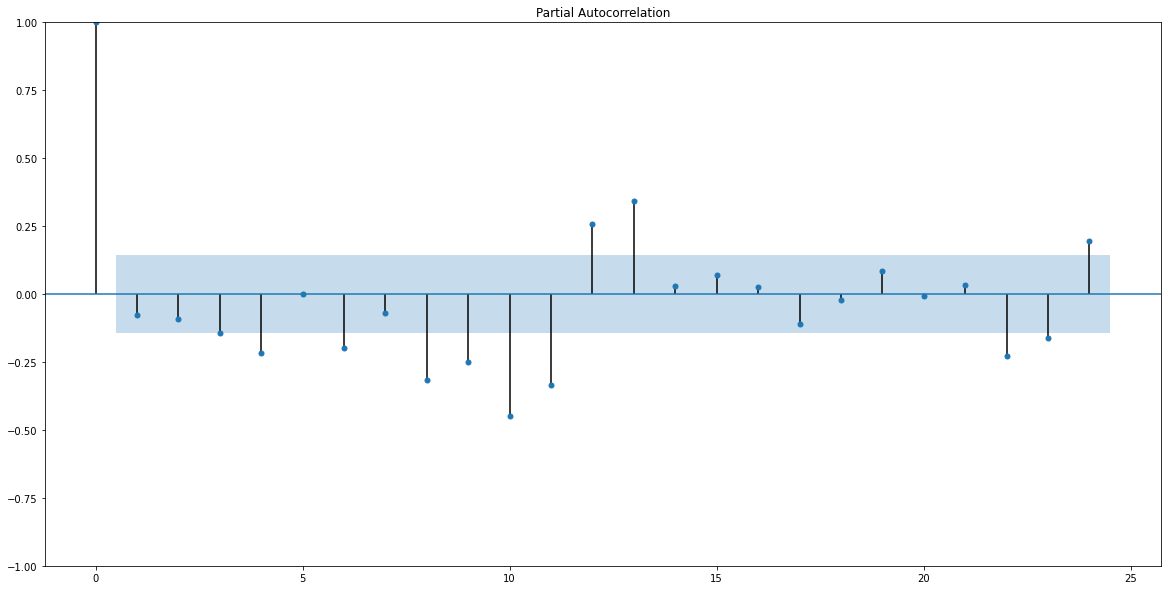

In [52]:
sm.graphics.tsa.plot_pacf(diff_ukdrivers, lags=24)
plt.show()

In [53]:
kps.should_diff(diff_ukdrivers)

(0.1, False)

**Anáise**

De acordo com a função de KPSSTest, o dados de acidentes do dataset UKDriverDeaths precisaria da função diff, mas depois do primeiro diff, o KPSSTest já indicou False no teste.

##Criação do modelo com auto_arima - UKDriverDeaths## 

In [54]:
auto_arima(df_ukdrivers['UKDriverDeaths'], # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=12, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2607.707, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2538.987, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2563.110, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2605.707, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2608.535, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2528.667, Time=0.97 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2523.079, Time=1.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2520.319, Time=0.48 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2564.471, Time=0.40 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2522.829, Time=1.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2557.524, Time=1.01 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=2520.990, Time=1.28 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2530.955, Time=0.45 sec
 ARIMA(2,1,0)(1,0,1)[12]

ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={},
      seasonal_order=(1, 0, 2, 12), suppress_warnings=True,
      with_intercept=False)

## Predict com auto_arima e 1 step and direct

In [55]:
df_arima_ukdrivers = arima_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28)

training shape (164,)
test shape (28,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2154.032, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2232.950, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2169.136, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2188.922, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2230.950, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2175.145, Time=0.45 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2161.230, Time=0.49 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2157.420, Time=0.75 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2154.785, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2207.150, Time=0.12 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2173.860, Time=0.65 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2159.003, Time=0.64 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2156.701, Time=0.73 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2155

100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


##Predict com auto_arima e 10 steps.#

In [56]:
arima_hsteps_uk = arima_horizon_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28, 10)
df_arima_ukdrivers['arima_10step'] = arima_hsteps_uk['arima_10step'].values

training shape (155,)
test shape (37,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2042.835, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2115.528, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2053.714, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2073.538, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2113.533, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2062.468, Time=0.25 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2048.565, Time=0.26 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2045.565, Time=0.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2044.305, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2094.160, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2060.842, Time=0.62 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2046.491, Time=0.59 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2044.848, Time=0.76 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2046

  0%|          | 0/37 [00:00<?, ?it/s]

fim do treino 155


  3%|▎         | 1/37 [00:00<00:10,  3.48it/s]

fim do treino 156


  5%|▌         | 2/37 [00:00<00:10,  3.35it/s]

fim do treino 157


  8%|▊         | 3/37 [00:00<00:11,  3.06it/s]

fim do treino 158


 11%|█         | 4/37 [00:01<00:10,  3.09it/s]

fim do treino 159


 14%|█▎        | 5/37 [00:01<00:10,  3.17it/s]

fim do treino 160


 16%|█▌        | 6/37 [00:01<00:09,  3.14it/s]

fim do treino 161


 19%|█▉        | 7/37 [00:02<00:09,  3.18it/s]

fim do treino 162


 22%|██▏       | 8/37 [00:02<00:08,  3.24it/s]

fim do treino 163


 24%|██▍       | 9/37 [00:02<00:08,  3.22it/s]

fim do treino 164


 27%|██▋       | 10/37 [00:03<00:08,  3.22it/s]

fim do treino 165


 30%|██▉       | 11/37 [00:03<00:08,  3.14it/s]

fim do treino 166


 32%|███▏      | 12/37 [00:03<00:07,  3.24it/s]

fim do treino 167


 35%|███▌      | 13/37 [00:04<00:07,  3.16it/s]

fim do treino 168


 38%|███▊      | 14/37 [00:04<00:07,  3.18it/s]

fim do treino 169


 41%|████      | 15/37 [00:04<00:07,  3.05it/s]

fim do treino 170


 43%|████▎     | 16/37 [00:05<00:06,  3.06it/s]

fim do treino 171


 46%|████▌     | 17/37 [00:05<00:06,  3.13it/s]

fim do treino 172


 49%|████▊     | 18/37 [00:05<00:06,  3.09it/s]

fim do treino 173


 51%|█████▏    | 19/37 [00:06<00:05,  3.04it/s]

fim do treino 174


 54%|█████▍    | 20/37 [00:06<00:05,  3.08it/s]

fim do treino 175


 57%|█████▋    | 21/37 [00:06<00:05,  3.11it/s]

fim do treino 176


 59%|█████▉    | 22/37 [00:06<00:04,  3.12it/s]

fim do treino 177


 62%|██████▏   | 23/37 [00:07<00:04,  3.11it/s]

fim do treino 178


 65%|██████▍   | 24/37 [00:07<00:04,  3.07it/s]

fim do treino 179


 68%|██████▊   | 25/37 [00:07<00:03,  3.05it/s]

fim do treino 180


 70%|███████   | 26/37 [00:08<00:03,  3.01it/s]

fim do treino 181


 73%|███████▎  | 27/37 [00:08<00:03,  2.99it/s]

fim do treino 182


 76%|███████▌  | 28/37 [00:08<00:02,  3.02it/s]

fim do treino 183


 78%|███████▊  | 29/37 [00:09<00:02,  2.96it/s]

fim do treino 184


 81%|████████  | 30/37 [00:09<00:02,  3.00it/s]

fim do treino 185


 84%|████████▍ | 31/37 [00:10<00:02,  2.59it/s]

fim do treino 186


 86%|████████▋ | 32/37 [00:10<00:02,  2.16it/s]

fim do treino 187


 89%|████████▉ | 33/37 [00:11<00:02,  1.80it/s]

fim do treino 188


 92%|█████████▏| 34/37 [00:12<00:01,  1.67it/s]

fim do treino 189


 95%|█████████▍| 35/37 [00:12<00:01,  1.61it/s]

fim do treino 190


 97%|█████████▋| 36/37 [00:13<00:00,  1.56it/s]

fim do treino 191


100%|██████████| 37/37 [00:14<00:00,  2.56it/s]


## Plot das previões com auto_arima: Direct, 1 step, 10 steps e real.

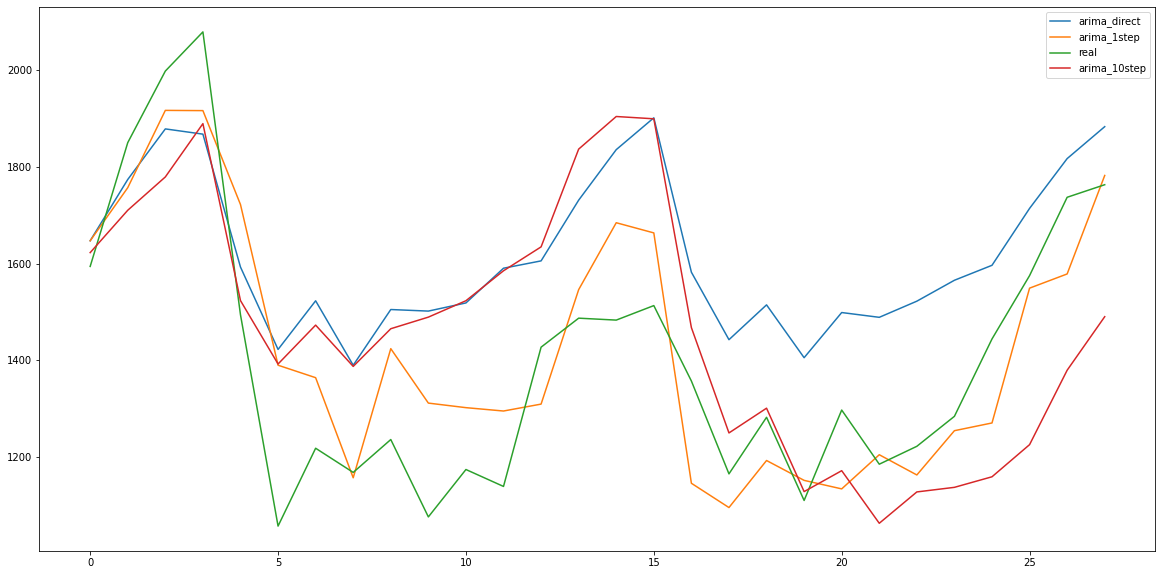

In [57]:
df_arima_ukdrivers.plot()
plt.show()

In [58]:
df_arima_ukdrivers.head()

,arima_direct,arima_1step,real,arima_10step
0,1647.067318,1647.067318,1594,1622.541527
1,1773.800280,1756.854602,1850,1710.168409
2,1878.409270,1916.719736,1998,1779.060289
3,1867.572143,1916.220783,2079,1889.312777
4,1592.733404,1721.995825,1494,1523.367674


In [59]:
df_arima_ukdrivers.shape

(28, 4)

##Plot das previões realizadas junto com os dados reais através do tempo.

(164,) (164,) (28,) (28,)


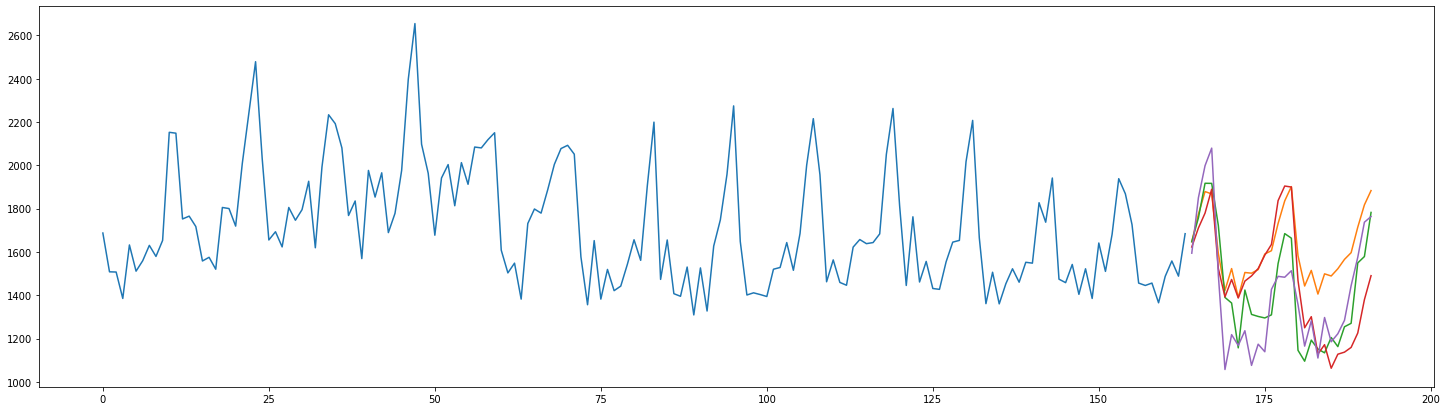

In [60]:
plot_predict(df_ukdrivers['UKDriverDeaths'], df_arima_ukdrivers, 28)

##Cálculo do Erro   - UKDriversDeath##

In [61]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'arima_10step']:

  dict_result = gerenerate_metric_results(df_arima_ukdrivers['real'], df_arima_ukdrivers[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,68914.319023,262.515369,18.607111,239.755170,4.951902,1.001840,85.714286,arima_direct
1,20984.640595,144.860763,9.102848,121.589842,0.728353,0.335540,67.857143,arima_1step
2,66186.024977,257.266447,16.294891,221.554121,3.227909,1.001163,82.142857,arima_10step


##Definição da MLP - UKDriversDeath##

**Criação do Modelo MLPRegressor e previsão dos dados**


In [84]:
ts_pydataset = df_ukdrivers['UKDriverDeaths']
test_size_uk = 28
use_diff_uk = True

prevs_mlp_1step_uk, prevs_mlp_10step_uk = create_mlp_model(ts_pydataset, test_size_uk, use_diff_uk)

-- MLPRegressor --
Análise 1step:
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões

Análise 10step:
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões
Previsões 1step e 10step criados


**Criação do Modelo SVR e previsão dos dados**


In [85]:
prevs_svr_1step_uk, prevs_svr_10step_uk = create_svr_model(ts_pydataset, test_size_uk, use_diff_uk)

-- SVR --
Análise 1step:
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões

Análise 10step:
Criando windowing
Encontrado os melhores parâmetros
Treinando o modelo
Gerando as previsões
Previsões 1step e 10step criados


In [86]:
df_arima_ukdrivers['prevs_mlp_1step'] = prevs_mlp_1step_uk
df_arima_ukdrivers['prevs_mlp_10step'] = prevs_mlp_10step_uk
df_arima_ukdrivers['prevs_svr_1step'] = prevs_svr_1step_uk
df_arima_ukdrivers['prevs_svr_10step'] = prevs_svr_10step_uk

In [87]:
list_result = []
for m in ['arima_direct', 'arima_1step', 'prevs_mlp_1step', 'prevs_svr_1step', 'arima_10step', 'prevs_mlp_10step', 'prevs_svr_10step']:

  dict_result = gerenerate_metric_results(df_arima_ukdrivers['real'], df_arima_ukdrivers[m])
  dict_result['name'] = m
  list_result.append(dict_result)

pd.DataFrame(list_result)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,name
0,68914.319023,262.515369,18.607111,239.755170,4.951902,1.001840,85.714286,arima_direct
1,20984.640595,144.860763,9.102848,121.589842,0.728353,0.335540,67.857143,arima_1step
2,139584.774512,373.610458,26.133349,329.685763,387.143369,1.786772,50.000000,prevs_mlp_1step
3,53934.195429,232.237369,14.309165,190.396315,3.801900,0.937911,50.000000,prevs_svr_1step
4,66186.024977,257.266447,16.294891,221.554121,3.227909,1.001163,82.142857,arima_10step
5,66538.680282,257.950926,15.448472,205.587933,5.761126,1.020550,53.571429,prevs_mlp_10step
6,71242.138807,266.912231,15.757042,210.131126,5.001278,1.049549,42.857143,prevs_svr_10step


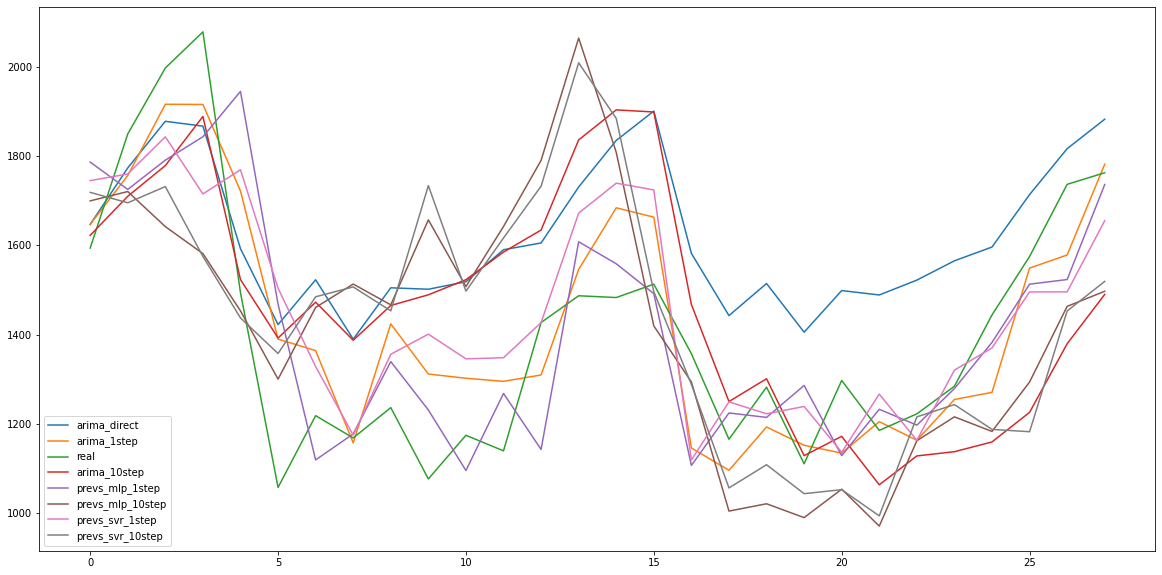

In [66]:
df_arima_ukdrivers.plot()

## Análise da série temporal "sem_nome"

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')
df_sem_nome = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/sem_nome.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [68]:
#df_sem_nome = pd.read_csv('sem_nome.csv')
#df_sem_nome
df_sem_nome.shape

(1000, 2)

**Análise**:

Na plotagem de todos os dados temporais, aparentemente não há uma tendência, mesmo fazendo um corte dos últimos 200 dados, difícil analisar se existe uma sazonalidade e ciclos.

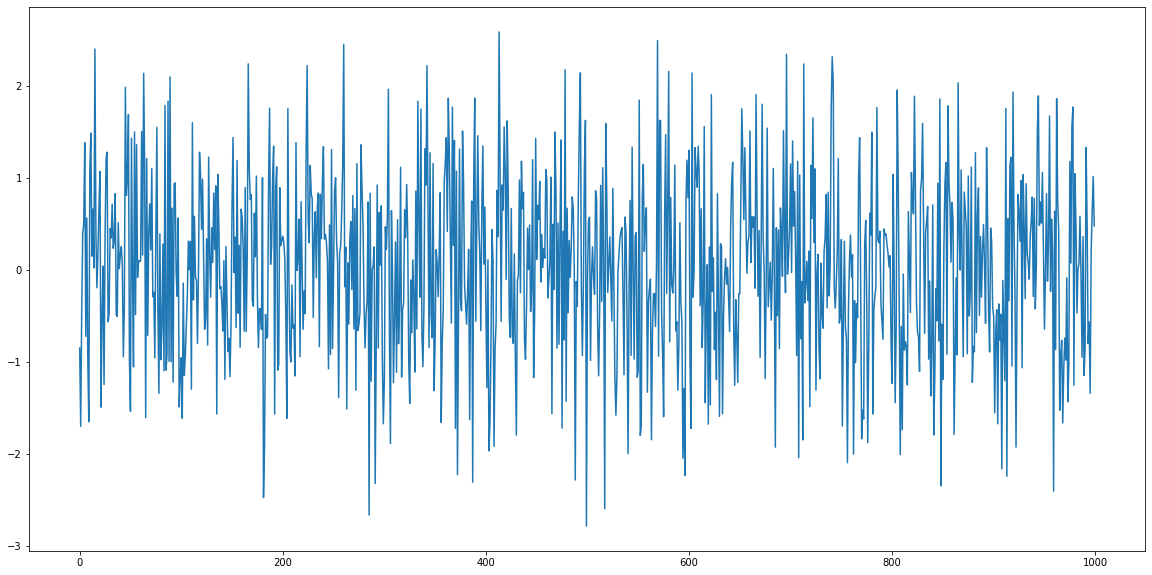

In [69]:
df_sem_nome['actual'].plot()

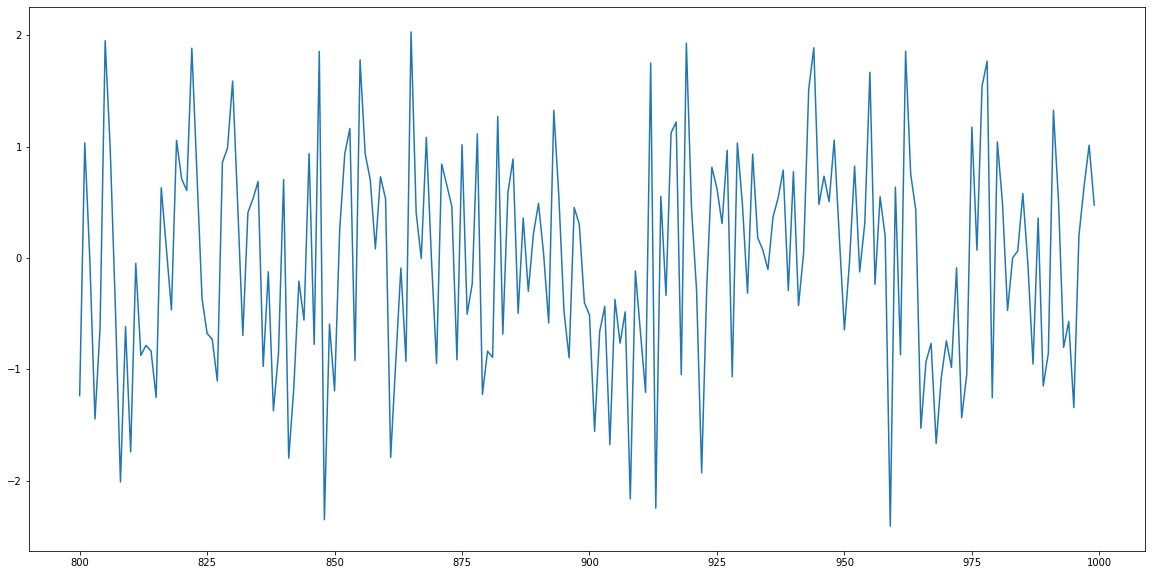

In [70]:
df_sem_nome['actual'].iloc[-200:].plot()

**Análise**:


Tanto no gráfico de correlação acumulada quanto na correlação parcial, não existe correlação entre os dados, nem mesmo no t-1. Média móvel bem próxima de zero indicando um caraterística de "Ruído Branco".

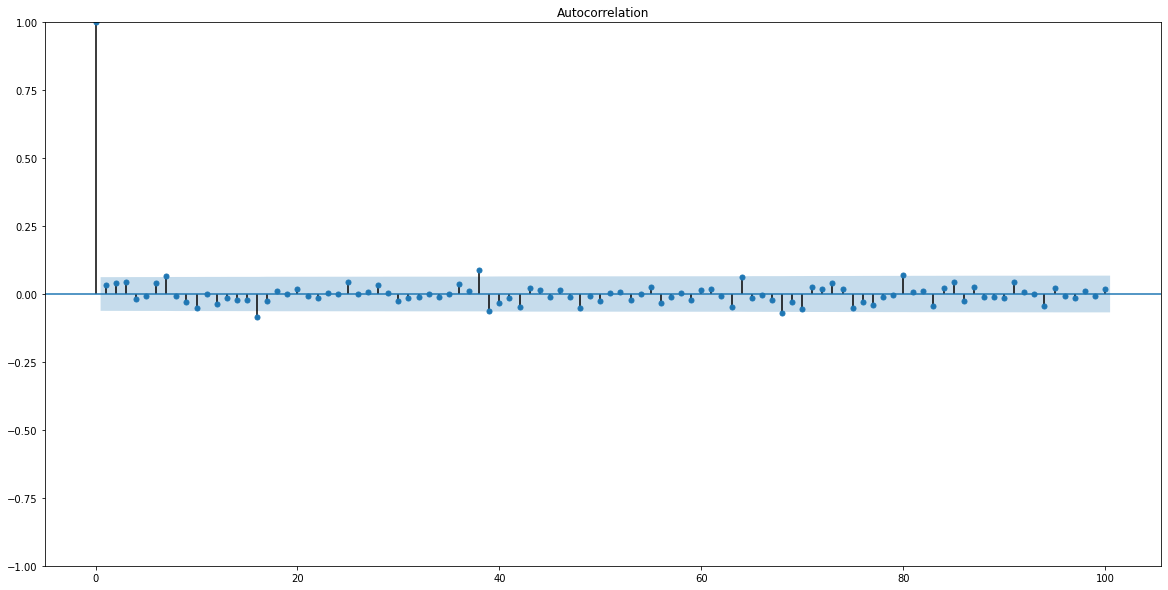

In [71]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

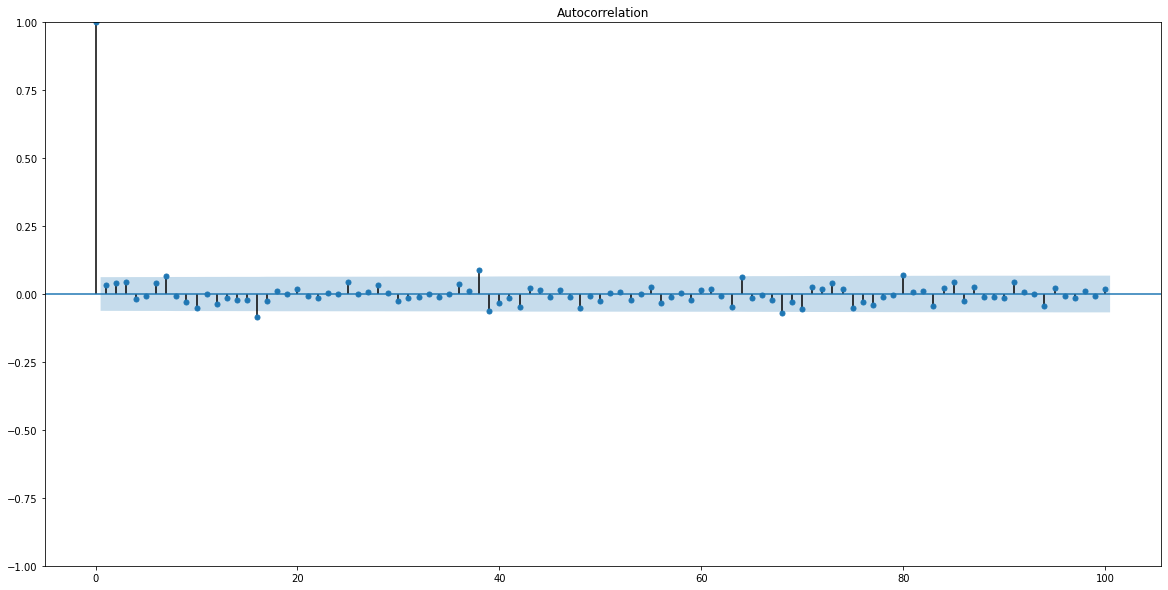

In [72]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

**Análise com função KPSSTest - sem_nome dataset**

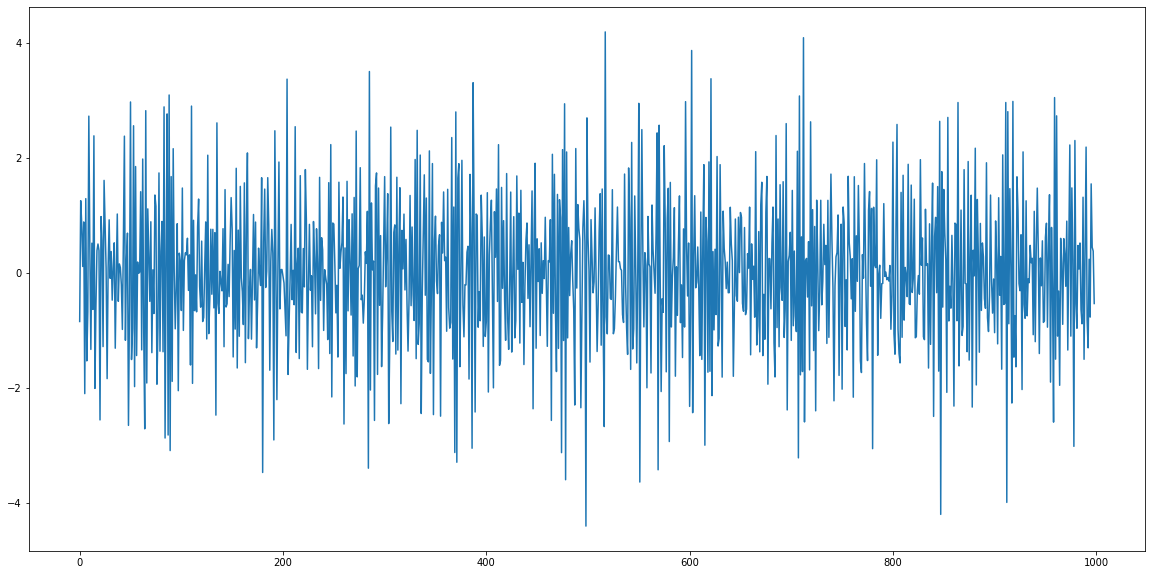

In [73]:
diff_semnome = differ(df_sem_nome['actual']) # ou ts.diff()
diff_semnome.plot()
plt.show()

In [74]:
kps.should_diff(df_sem_nome['actual'])

(0.1, False)

**Análise**

Verificando o KPSSTest para o dataset sem_nome, podemos ver que não seria necessário fazer o diff no dataset original.

Plotando os gráficos de ACF e PACF para o diff do dataset.

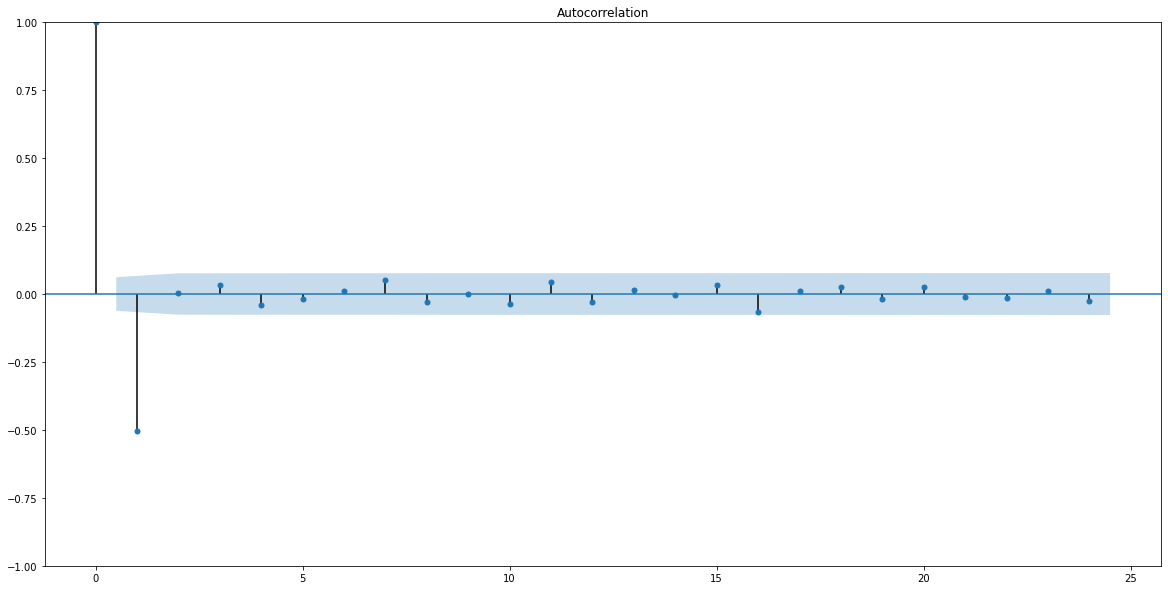

In [75]:
sm.graphics.tsa.plot_acf(diff_semnome, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


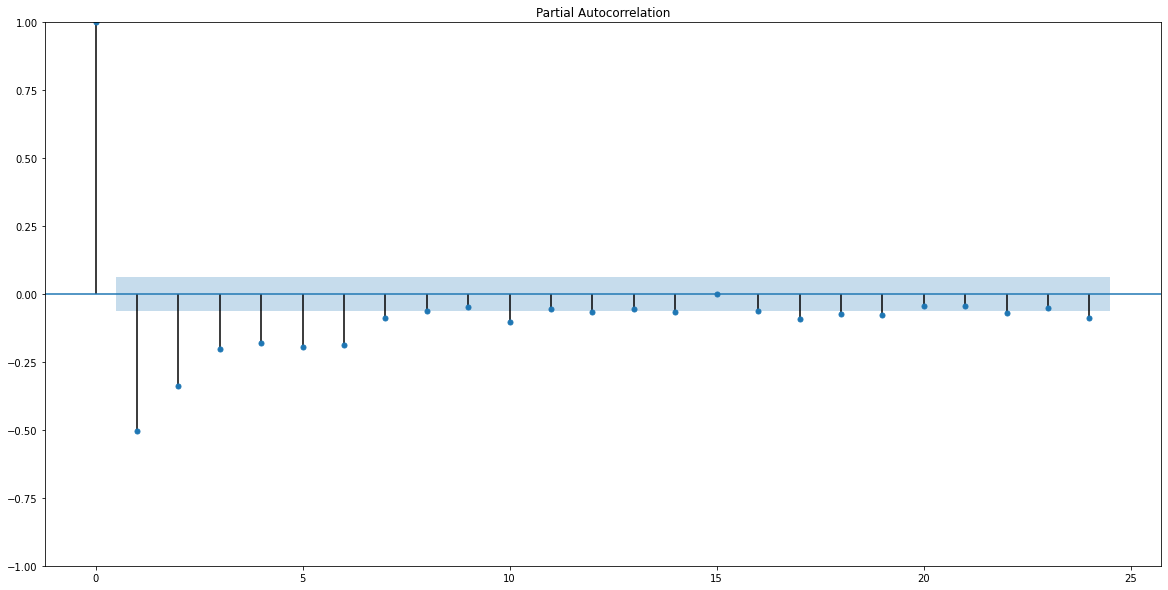

In [76]:
sm.graphics.tsa.plot_pacf(diff_semnome, lags=24)
plt.show()

##Análise ARIMA e ARIMA Sazonal##

In [77]:
white_noise = np.random.normal(size=1000)

In [78]:
c  = 10
ar1 = [1]
peso = 0.5

for i in range(0, len(white_noise)):
  ar1.append(c  + (peso*ar1[i]) + white_noise[i])


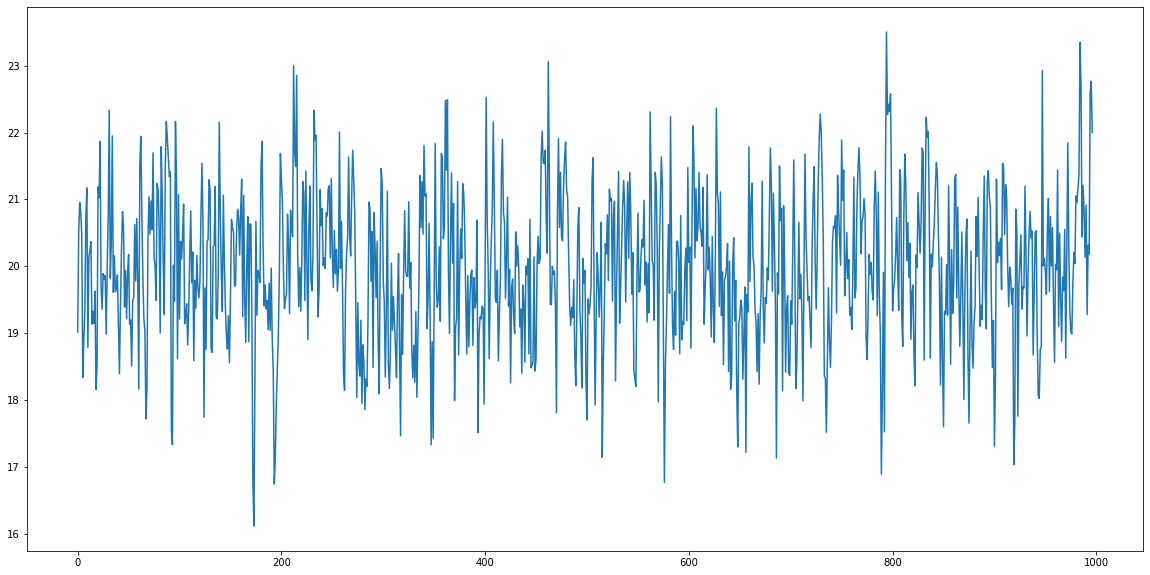

In [79]:
pd.Series(ar1[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


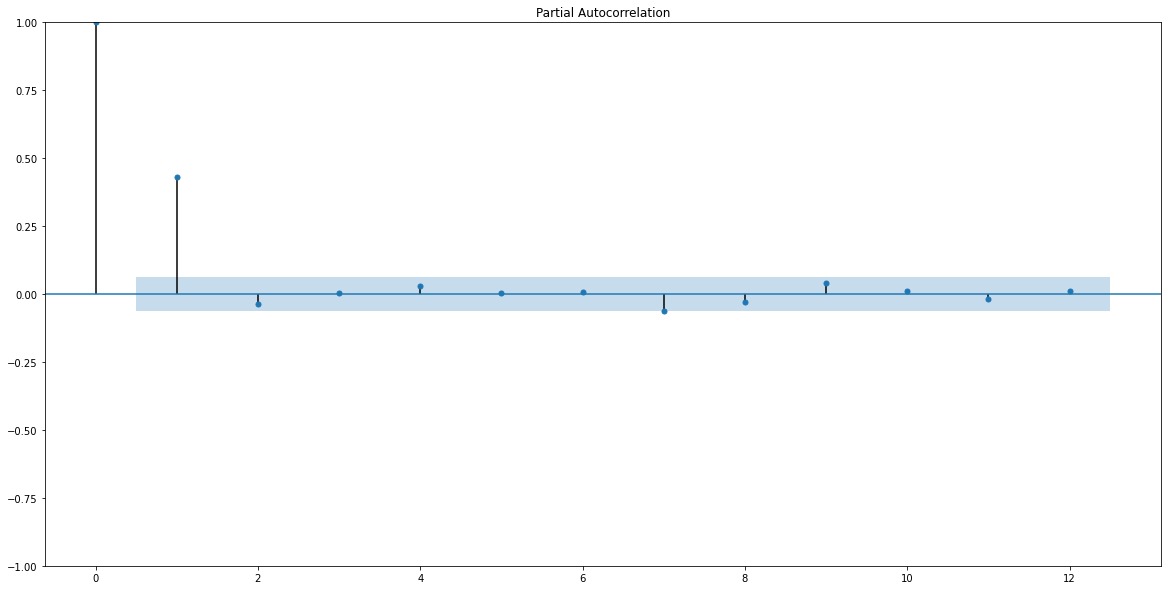

In [80]:
sm.graphics.tsa.plot_pacf(ar1[4:], lags=12)
plt.show()

In [81]:
c  = 10
ar2 = [1, 3]
peso1 = 0.4
peso2 = - 0.5 

for i in range(0, len(white_noise)):
  ar2.append(c  + (peso2*ar2[i]) + (peso1*ar2[i+1]) + white_noise[i])


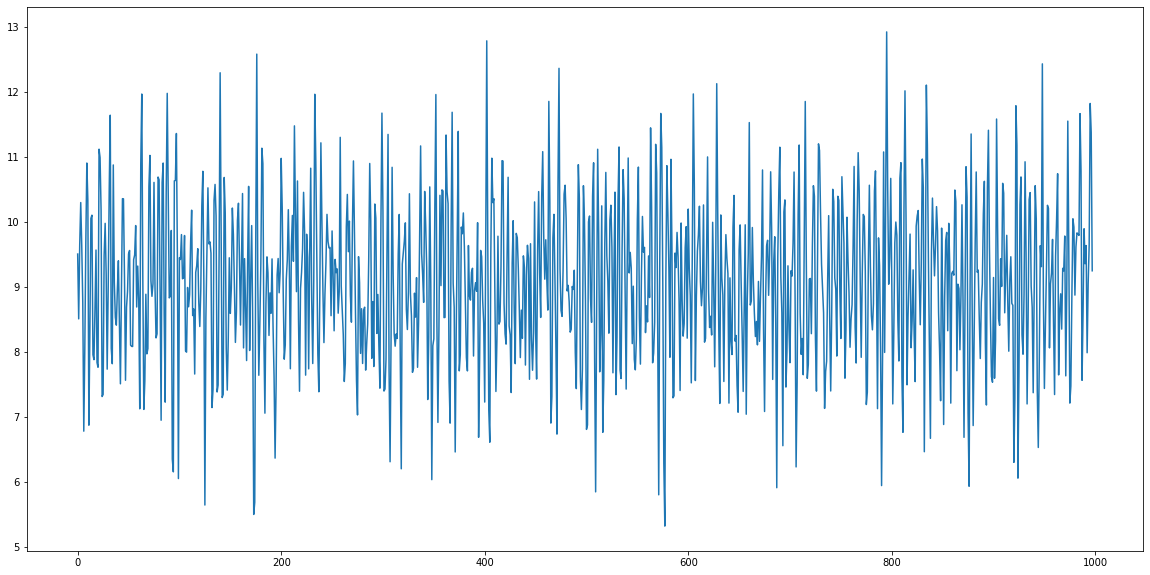

In [82]:
pd.Series(ar2[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


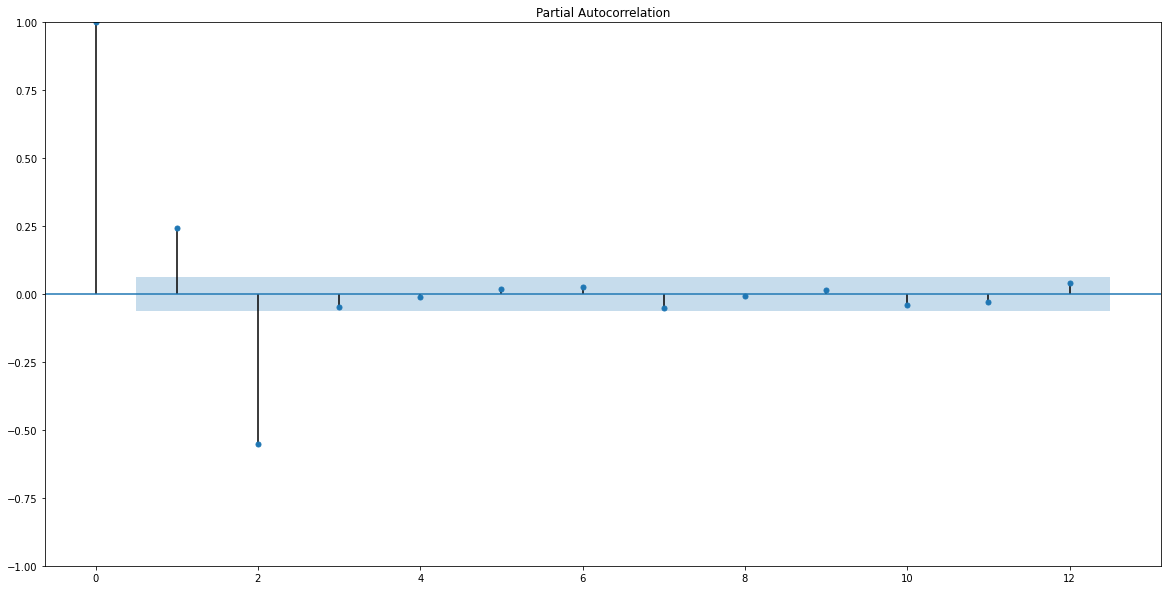

In [83]:
sm.graphics.tsa.plot_pacf(ar2[4:], lags=12)
plt.show()